# SenNet + HOA - Hacking the Human Vasculature in 3D

## Importing Libraries

In [13]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import tifffile as tiff
import cv2
import torch.nn as nn
import albumentations as A
import numpy as np
import os
import time
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [14]:
import random
# Set seed first for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [15]:
!nvidia-smi

Wed Dec  3 18:23:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Sample Original Image & Label

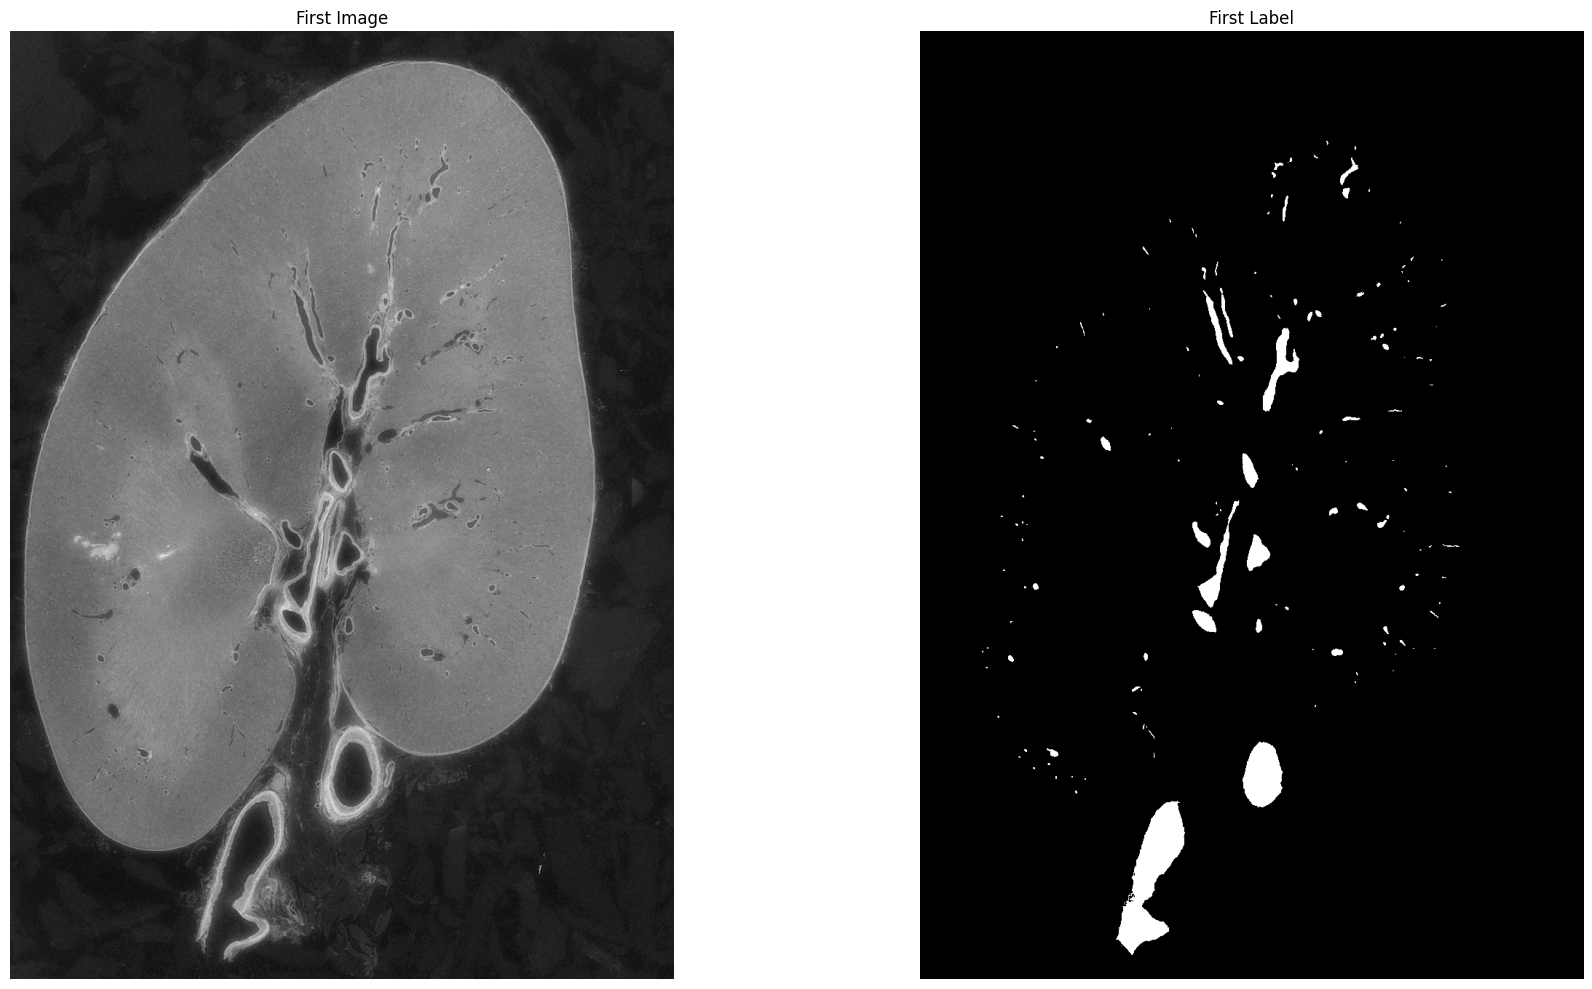

In [16]:
base_path = '/kaggle/input/blood-vessel-segmentation/train'  

dataset = 'kidney_1_dense'

images_path = os.path.join(base_path, dataset, 'images')
labels_path = os.path.join(base_path, dataset, 'labels')

image_files = sorted([os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith('.tif')])
label_files = sorted([os.path.join(labels_path, f) for f in os.listdir(labels_path) if f.endswith('.tif')])

def show_images(images,titles= None, cmap='gray'):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(20, 10))
    if not isinstance(axes, np.ndarray):
        axes = [axes]
    for idx, ax in enumerate(axes):
        ax.imshow(images[idx], cmap=cmap)
        if titles:
            ax.set_title(titles[idx])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

first_image = tiff.imread(image_files[981])
first_label = tiff.imread(label_files[981])

show_images([first_image, first_label], titles=['First Image', 'First Label'])

## Dataloader

In [17]:

class CustomDataset(Dataset):
    def __init__(self, image_files, mask_files, input_size=(256, 256), augmentation_transforms=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.input_size = input_size
        self.augmentation_transforms = augmentation_transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
       
        image_path = self.image_files[idx]
        mask_path = self.mask_files[idx]

        image = preprocess_image(image_path)
        mask = preprocess_mask(mask_path)

        if self.augmentation_transforms:
            image, mask = self.augmentation_transforms(image, mask)

        return image, mask

## Preprocessing of Images

In [18]:
def preprocess_image(path):
    
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = np.tile(img[...,None],[1, 1, 3]) 
    img = img.astype('float32') 
    mx = np.max(img)
    if mx:
        img/=mx 
        
    img = np.transpose(img, (2, 0, 1))
    img_ten = torch.tensor(img)
    return img_ten

## Preprocessing of Masks

In [19]:
def preprocess_mask(path):
    
    msk = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    msk = msk.astype('float32')
    msk/=255.0
    msk_ten = torch.tensor(msk)
    
    return msk_ten

## Augmentation

In [20]:
def augment_image(image, mask):
    
    
    image_np = image.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()

    transform = A.Compose([
        A.Resize(256,256, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        A.RandomCrop(height=256, width=256, always_apply=True),
        A.RandomBrightness(p=1),
        A.OneOf(
            [
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
    
    ])

    augmented = transform(image=image_np, mask=mask_np)
    augmented_image, augmented_mask = augmented['image'], augmented['mask']

    augmented_image = torch.tensor(augmented_image, dtype=torch.float32).permute(2, 0, 1)
    augmented_mask = torch.tensor(augmented_mask, dtype=torch.float32)

    return augmented_image, augmented_mask

In [21]:
base_path = '/kaggle/input/blood-vessel-segmentation/train'  

dataset = 'kidney_1_dense'

images_path = os.path.join(base_path, dataset, 'images')
labels_path = os.path.join(base_path, dataset, 'labels')

image_files = sorted([os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith('.tif')])
label_files = sorted([os.path.join(labels_path, f) for f in os.listdir(labels_path) if f.endswith('.tif')])

## Splitting the Dataset

In [22]:
train_image_files, val_image_files, train_mask_files, val_mask_files = train_test_split(
    image_files, label_files, test_size=0.2, random_state=42)

In [23]:
train_dataset = CustomDataset(train_image_files, train_mask_files, augmentation_transforms=augment_image)
val_dataset = CustomDataset(val_image_files, val_mask_files, augmentation_transforms=augment_image)

In [24]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

## Augmented Batch_1 Images & Labels Viz.

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


Batch 1
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Foreground ratio: 0.005619049072265625


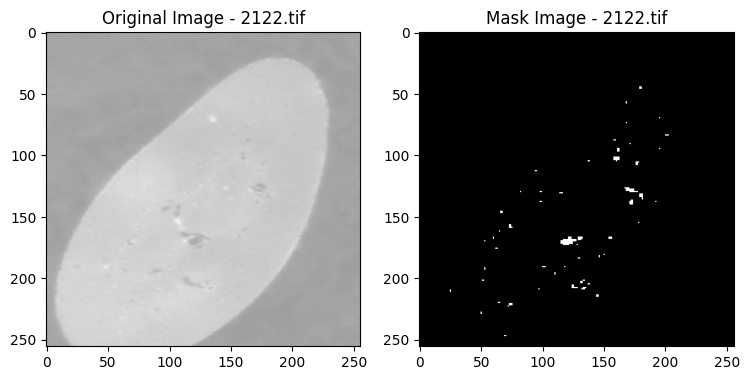

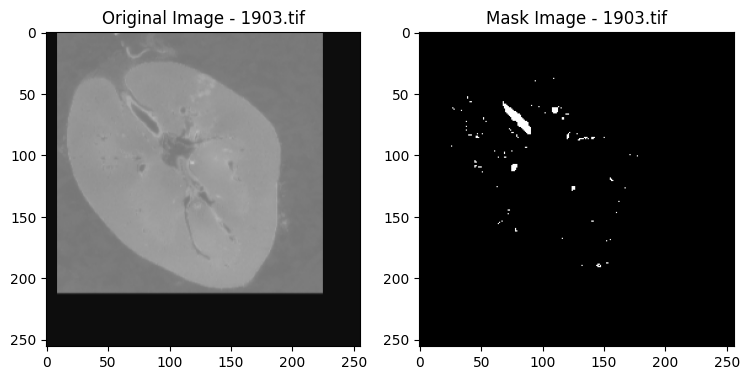

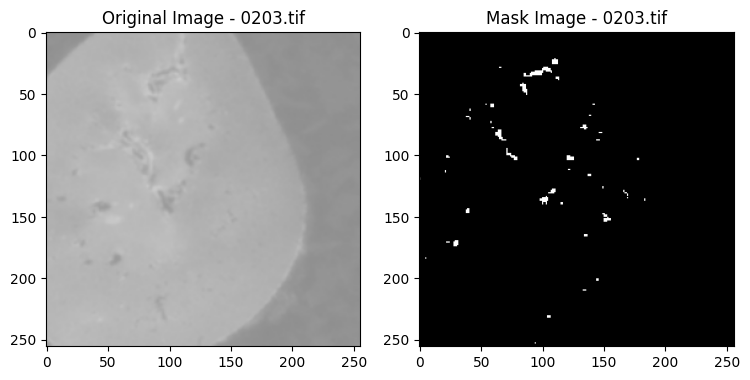

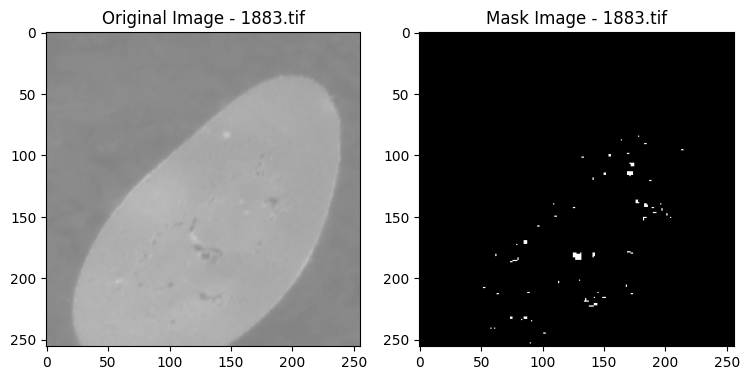

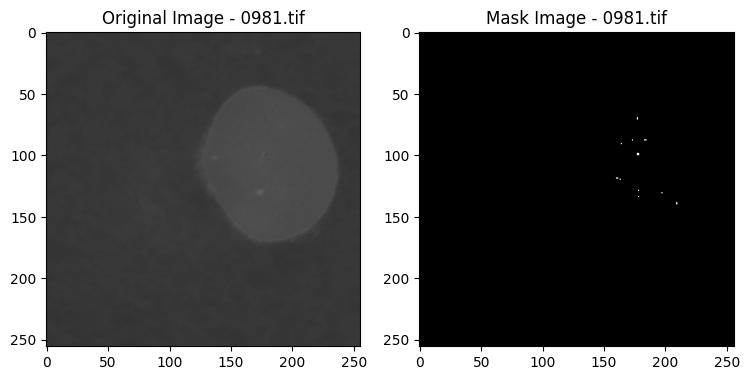

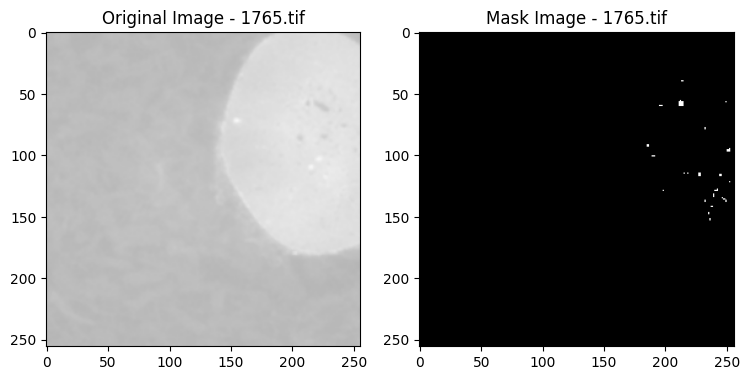

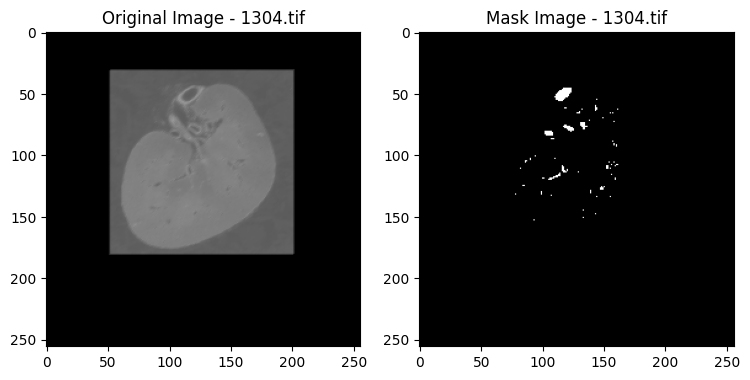

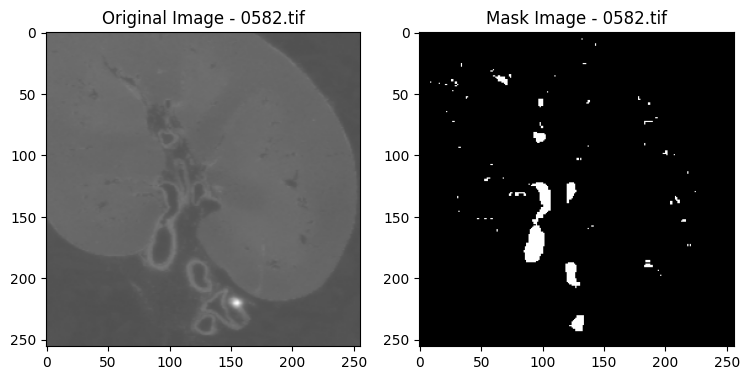

In [25]:
for batch_idx, (batch_images, batch_masks) in enumerate(train_dataloader):
    print("Batch", batch_idx + 1)
    print("Image batch shape:", batch_images.shape)
    print("Mask batch shape:", batch_masks.shape)
    
    # batch_masks shape: [B, H, W]
    foreground = batch_masks.sum().item()  # total foreground pixels
    total = batch_masks.numel()            # total pixels in batch
    print("Foreground ratio:", foreground / total)
    
    for image, mask, image_path, mask_path in zip(batch_images, batch_masks, train_image_files, train_mask_files):
       
        image = image.permute((1, 2, 0)).numpy()*255.0
        image = image.astype('uint8')
        mask = (mask*255).numpy().astype('uint8')
        
        image_filename = os.path.basename(image_path)
        mask_filename = os.path.basename(mask_path)
        
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 4, 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Original Image - {image_filename}")
        
        plt.subplot(2, 4, 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Mask Image - {mask_filename}")
        
        plt.tight_layout()
        plt.show()
    break

In [28]:
for batch_idx, (batch_images, batch_masks) in enumerate(train_dataloader):
    print("Batch", batch_idx + 1)
    print("Image batch shape:", batch_images.shape)
    print("Mask batch shape:", batch_masks.shape)

Batch 1
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 2
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 3
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 4
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 5
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 6
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 7
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 8
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 9
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 10
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])

In [ ]:
for batch_idx, (batch_images, batch_masks) in enumerate(val_dataloader):
    print("Batch", batch_idx + 1)
    print("Image batch shape:", batch_images.shape)
    print("Mask batch shape:", batch_masks.shape)

In [26]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
device

device(type='cuda')

## Attention U-Net architecture

One thing that is worth noticing, is that I had to add some black padding around images. It is because, I am using U-Net - like architecture with learnable visual attention blocks, and spatial dimensions of signal coming from skip connections and their corresponging feature maps must fit together. That is why the pictures after padding have size (592, 576) - they can be downsampled using max pooling 4 times (the dimensions are possible to divide by 4).

The picture that helps to understand the U-Net architecture is given below. It is a encoder-decoder architecture, that means that input image is first downsampled using max pooling. This process produces feature maps, that is semantic features coming from imput image. Then, the feature maps are upsampled again, to classify each pixel in the image. To make this process more accurate, authors of the architecture decided to use skip connections: signal from feature maps is combined with input image. It helps to decide precisely, which picture should be considered positive class (in this case: blood vessel) and which one should be marked as a background.

The picture's source is the U-Net paper.

![alt text](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

Recently, the field of Deep Learning is evolving extremely fast. New ideas and architectures are proposed frequently. One of them, that helped to improve NLP is attention. It is an idea that we can try to make our model focus on certain parts of the incoming signal (in case of text: sequences of words, in case of images: matrices with their digital representation). Computer Vision community, inspired by the work of their colleagues, have developed an idea of visual attention. For example the paper "Learn to pay attention" by Jetley et al describes the usage of learnable attention gate, that is additional blocks that gather signals from different layers of the network and learn where useful information from the image is. The prediction is made by concatenating the output from the attention blocks, and not by making use of the last layer of the network directly. The image from the article that describes the idea is given below: ![alt text](https://miro.medium.com/max/616/0*8r63L3yR66SVBgJR)

This idea was futher developed for semantic segmentation tasks by Oktay et al in the article "Attention U-Net: Learning Where to Look for the Pancreas". The difference is that attention blocks are now learning to filter signal from skip connections by estimating the information coming from them by comparing it with features from feature maps.
![alt text](https://miro.medium.com/max/780/1*PdYEf-OuUWkRsm2Lfrmy6A.png)


I decided to use this idea for my dataset, because it might work quite well, and also I would learn a lot.

In [27]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class UpConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()

        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

# #OPTION 1 additive attention block (default):
# class AttentionBlock(nn.Module):
#     """Attention block with learnable parameters"""

#     def __init__(self, F_g, F_l, n_coefficients):
#         """
#         :param F_g: number of feature maps (channels) in previous layer
#         :param F_l: number of feature maps in corresponding encoder layer, transferred via skip connection
#         :param n_coefficients: number of learnable multi-dimensional attention coefficients
#         """
#         super(AttentionBlock, self).__init__()

#         self.W_gate = nn.Sequential(
#             nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
#             nn.BatchNorm2d(n_coefficients)
#         )

#         self.W_x = nn.Sequential(
#             nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
#             nn.BatchNorm2d(n_coefficients)
#         )

#         self.psi = nn.Sequential(
#             nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
#             nn.BatchNorm2d(1),
#             nn.Sigmoid()
#         )

#         self.relu = nn.ReLU(inplace=True)

#     def forward(self, gate, skip_connection):
#         """
#         :param gate: gating signal from previous layer
#         :param skip_connection: activation from corresponding encoder layer
#         :return: output activations
#         """
#         g1 = self.W_gate(gate)
#         x1 = self.W_x(skip_connection)
#         psi = self.relu(g1 + x1)
#         psi = self.psi(psi)
#         out = skip_connection * psi
#         return out
        
# OPTION 2 multiplicative attention block:
# class AttentionBlock(nn.Module):
#     """Attention block using multiplicative (dot-product) attention"""

#     def __init__(self, F_g, F_l, n_coefficients):
#         super(AttentionBlock, self).__init__()
#         self.W_gate = nn.Sequential(
#             nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
#             nn.BatchNorm2d(n_coefficients)
#         )
#         self.W_x = nn.Sequential(
#             nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
#             nn.BatchNorm2d(n_coefficients)
#         )
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, gate, skip_connection):
#         # Project features to same dimension
#         g1 = self.W_gate(gate)        # [B, n_coeff, H, W]
#         x1 = self.W_x(skip_connection) # [B, n_coeff, H, W]

#         # Multiplicative attention: element-wise multiplication
#         psi = g1 * x1                 # [B, n_coeff, H, W]

#         # Reduce channels to 1 using mean (or sum) across feature dimension
#         psi = psi.mean(dim=1, keepdim=True)  # [B, 1, H, W]

#         # Apply sigmoid to get attention mask
#         psi = self.sigmoid(psi)

#         # Apply mask to skip connection
#         out = skip_connection * psi
#         return out
#OPTION 3 multiplicative differential attention block:
# class AttentionBlock(nn.Module):
#     """Differential Attention Block for UNet"""

#     def __init__(self, F_g, F_l, n_coefficients):
#         super(AttentionBlock, self).__init__()
#         # First attention map
#         self.W_gate1 = nn.Sequential(
#             nn.Conv2d(F_g, n_coefficients, kernel_size=1, bias=True),
#             nn.BatchNorm2d(n_coefficients)
#         )
#         self.W_x1 = nn.Sequential(
#             nn.Conv2d(F_l, n_coefficients, kernel_size=1, bias=True),
#             nn.BatchNorm2d(n_coefficients)
#         )
#         # Second attention map
#         self.W_gate2 = nn.Sequential(
#             nn.Conv2d(F_g, n_coefficients, kernel_size=1, bias=True),
#             nn.BatchNorm2d(n_coefficients)
#         )
#         self.W_x2 = nn.Sequential(
#             nn.Conv2d(F_l, n_coefficients, kernel_size=1, bias=True),
#             nn.BatchNorm2d(n_coefficients)
#         )

#         self.sigmoid = nn.Sigmoid()

#     def forward(self, gate, skip_connection):
#         # Attention map 1
#         g1 = self.W_gate1(gate)
#         x1 = self.W_x1(skip_connection)
#         psi1 = g1 * x1
#         psi1 = psi1.mean(dim=1, keepdim=True)

#         # Attention map 2
#         g2 = self.W_gate2(gate)
#         x2 = self.W_x2(skip_connection)
#         psi2 = g2 * x2
#         psi2 = psi2.mean(dim=1, keepdim=True)

#         # Differential attention
#         psi_diff = self.sigmoid(psi1 - psi2)

#         # Apply mask
#         out = skip_connection * psi_diff
#         return out
#OPTION 4 additive differential attention block:
class AttentionBlock(nn.Module):
    """Additive Differential Attention Block for UNet"""

    def __init__(self, F_g, F_l, n_coefficients):
        super(AttentionBlock, self).__init__()

        # First attention map
        self.W_gate1 = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )
        self.W_x1 = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        # Second attention map
        self.W_gate2 = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )
        self.W_x2 = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        # Common psi
        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip_connection):
        # Attention map 1 (additive)
        g1 = self.W_gate1(gate)
        x1 = self.W_x1(skip_connection)
        psi1 = self.relu(g1 + x1)
        psi1 = self.psi(psi1)

        # Attention map 2 (additive)
        g2 = self.W_gate2(gate)
        x2 = self.W_x2(skip_connection)
        psi2 = self.relu(g2 + x2)
        psi2 = self.psi(psi2)

        # Differential attention: subtract two additive maps
        psi_diff = torch.sigmoid(psi1 - psi2)

        # Apply mask
        out = skip_connection * psi_diff
        return out



class AttentionUNet(nn.Module):

    def __init__(self, img_ch=3, output_ch=1):
        super(AttentionUNet, self).__init__()

        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = ConvBlock(img_ch, 64)
        self.Conv2 = ConvBlock(64, 128)
        self.Conv3 = ConvBlock(128, 256)
        self.Conv4 = ConvBlock(256, 512)
        self.Conv5 = ConvBlock(512, 1024)

        self.Up5 = UpConv(1024, 512)
        self.Att5 = AttentionBlock(F_g=512, F_l=512, n_coefficients=256)
        self.UpConv5 = ConvBlock(1024, 512)

        self.Up4 = UpConv(512, 256)
        self.Att4 = AttentionBlock(F_g=256, F_l=256, n_coefficients=128)
        self.UpConv4 = ConvBlock(512, 256)

        self.Up3 = UpConv(256, 128)
        self.Att3 = AttentionBlock(F_g=128, F_l=128, n_coefficients=64)
        self.UpConv3 = ConvBlock(256, 128)

        self.Up2 = UpConv(128, 64)
        self.Att2 = AttentionBlock(F_g=64, F_l=64, n_coefficients=32)
        self.UpConv2 = ConvBlock(128, 64)

        self.Conv = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        """
        e : encoder layers
        d : decoder layers
        s : skip-connections from encoder layers to decoder layers
        """
        e1 = self.Conv1(x)

        e2 = self.MaxPool(e1)
        e2 = self.Conv2(e2)

        e3 = self.MaxPool(e2)
        e3 = self.Conv3(e3)

        e4 = self.MaxPool(e3)
        e4 = self.Conv4(e4)

        e5 = self.MaxPool(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)

        s4 = self.Att5(gate=d5, skip_connection=e4)
        d5 = torch.cat((s4, d5), dim=1) 
        d5 = self.UpConv5(d5)

        d4 = self.Up4(d5)
        s3 = self.Att4(gate=d4, skip_connection=e3)
        d4 = torch.cat((s3, d4), dim=1)
        d4 = self.UpConv4(d4)

        d3 = self.Up3(d4)
        s2 = self.Att3(gate=d3, skip_connection=e2)
        d3 = torch.cat((s2, d3), dim=1)
        d3 = self.UpConv3(d3)

        d2 = self.Up2(d3)
        s1 = self.Att2(gate=d2, skip_connection=e1)
        d2 = torch.cat((s1, d2), dim=1)
        d2 = self.UpConv2(d2)

        out = self.Conv(d2)

        return out

## Dice Coefficient

For segmenation task, Dice Coefficient is often used to measure performance of the models. I havn't used it as a loss function directly, because I read that training the model with such loss function is not always stable. I decided to use Focal loss, because it has this nice property that it focuses on imbalanced positive class. It was developed for object detection, but it can be used for segmenation too. In the dataset that I am using there is quite a big class imbalance - most of the pixels don't represent blood vessels.

The picture below help us understand Dice Coefficient intuitevely. It is a 2 * |AnB| / (|A| + |B|)

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1f/Intersection_of_sets_A_and_B.svg/1200px-Intersection_of_sets_A_and_B.svg.png)


In [28]:
def dice_coeff(prediction, target):

    mask = np.zeros_like(prediction)
    mask[prediction >= 0.5] = 1

    inter = np.sum(mask * target)
    union = np.sum(mask) + np.sum(target)
    epsilon = 1e-6
    result = np.mean(2 * inter / (union + epsilon))
    return result

## Focal Loss


The plot helped me understand the Focal Loss. It comes from the Focal Loss paper.
![alt text](https://miro.medium.com/max/1032/1*wLf0KMIzBsXPcxsN7yBrIA.png)

In [29]:
class FocalLoss(nn.modules.loss._WeightedLoss):

    def __init__(self, gamma=0, size_average=None, ignore_index=-100,
                 reduce=None, balance_param=1.0):
        super(FocalLoss, self).__init__(size_average)
        self.gamma = gamma
        self.size_average = size_average
        self.ignore_index = ignore_index
        self.balance_param = balance_param

    def forward(self, input, target):
        
        assert len(input.shape) == len(target.shape)
        assert input.size(0) == target.size(0)
        assert input.size(1) == target.size(1)

        logpt = - F.binary_cross_entropy_with_logits(input, target)
        pt = torch.exp(logpt)

        focal_loss = -((1 - pt) ** self.gamma) * logpt
        balanced_focal_loss = self.balance_param * focal_loss
        return balanced_focal_loss

In [30]:
dataloaders = {
    'training': train_dataloader,
    'test': val_dataloader
}

## Training and Testing Loop

In [31]:
!pip install surface-distance

  Obtaining dependency information for surface-distance from https://files.pythonhosted.org/packages/b0/61/45e9641801e043497a92bda1aa7e87dd933eafa1eed1d6be8dfc9736f939/surface_distance-0.1-py3-none-any.whl.metadata


In [32]:
from surface_distance import metrics

def compute_surface_dice_at_tolerance(surface_distances, tolerance_mm):
    distances_gt_to_pred = surface_distances["distances_gt_to_pred"]
    distances_pred_to_gt = surface_distances["distances_pred_to_gt"]
    surfel_areas_gt = surface_distances["surfel_areas_gt"]
    surfel_areas_pred = surface_distances["surfel_areas_pred"]

    overlap_gt = np.sum(surfel_areas_gt[distances_gt_to_pred <= tolerance_mm])
    overlap_pred = np.sum(surfel_areas_pred[distances_pred_to_gt <= tolerance_mm])

    return (overlap_gt + overlap_pred) / (
        np.sum(surfel_areas_gt) + np.sum(surfel_areas_pred)
    )


def compute_dice_coefficient(mask_gt, mask_pred):
    volume_sum = mask_gt.sum() + mask_pred.sum()
    if volume_sum == 0:
        return np.nan
    volume_intersect = (mask_gt & mask_pred).sum()
    return 2 * volume_intersect / volume_sum
    


def compute_surface_distances(mask_gt, mask_pred, spacing=(1.0, 1.0)):
    return metrics.compute_surface_distances(
        mask_gt.astype(bool),
        mask_pred.astype(bool),
        spacing_mm=spacing
    )

In [33]:
import time
import numpy as np
import torch

def train_and_test(model, dataloaders, optimizer, criterion, num_epochs=100, tolerance_mm=0.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, test_losses = [], []
    train_vol_dices, test_vol_dices = [], []
    train_surf_dices, test_surf_dices = [], []

    best_surface_dice = -1.0
    best_epoch = -1
    best_model_wts = None

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")
        print("-" * 30)

        epoch_stats = {
            "training": {"loss": 0.0, "vol": [], "surf": []},
            "test": {"loss": 0.0, "vol": [], "surf": []},
        }

        for phase in ["training", "test"]:
            model.train() if phase == "training" else model.eval()

            for sample in dataloaders[phase]:
                inputs = sample[0].to(device)
                masks = sample[1].unsqueeze(1).to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "training"):
                    outputs = model(inputs)
                    loss = criterion(outputs, masks)

                    if phase == "training":
                        loss.backward()
                        optimizer.step()

                # Apply sigmoid only for Dice computation
                probs = torch.sigmoid(outputs)

                # Convert to numpy
                preds = (probs.detach().cpu().numpy() >= 0.5)
                gts = masks.detach().cpu().numpy().astype(bool)

                batch_vol, batch_surf = [], []

                for i in range(preds.shape[0]):
                    gt = gts[i, 0]
                    pred = preds[i, 0]

                    # volumetric dice
                    vd = compute_dice_coefficient(gt, pred)

                    # surface dice
                    sd = compute_surface_dice_at_tolerance(
                        compute_surface_distances(gt, pred),
                        tolerance_mm=tolerance_mm
                    )

                    batch_vol.append(vd)
                    batch_surf.append(sd)

                epoch_stats[phase]["loss"] += loss.item() * inputs.size(0)
                epoch_stats[phase]["vol"].append(np.nanmean(batch_vol))
                epoch_stats[phase]["surf"].append(np.nanmean(batch_surf))

            epoch_stats[phase]["loss"] /= len(dataloaders[phase].dataset)

        # Aggregate over epoch
        train_losses.append(epoch_stats["training"]["loss"])
        test_losses.append(epoch_stats["test"]["loss"])

        train_vol_dices.append(np.mean(epoch_stats["training"]["vol"]))
        test_vol_dices.append(np.mean(epoch_stats["test"]["vol"]))

        train_surf_dices.append(np.mean(epoch_stats["training"]["surf"]))
        test_surf_dices.append(np.mean(epoch_stats["test"]["surf"]))

        print(
            f"Train Loss: {train_losses[-1]:.4f}, VolDice: {train_vol_dices[-1]:.4f}, SurfDice: {train_surf_dices[-1]:.4f}"
        )
        print(
            f"Test Loss:  {test_losses[-1]:.4f}, VolDice: {test_vol_dices[-1]:.4f}, SurfDice: {test_surf_dices[-1]:.4f}"
        )

        # Save best surface dice model
        if test_surf_dices[-1] > best_surface_dice:
            best_surface_dice = test_surf_dices[-1]
            best_epoch = epoch
            best_model_wts = model.state_dict()

    if best_model_wts:
        model.load_state_dict(best_model_wts)

    print(f"\nBest Surface Dice = {best_surface_dice:.5f} at epoch {best_epoch}")

    return (
        model,
        train_losses,
        test_losses,
        train_vol_dices,
        test_vol_dices,
        train_surf_dices,
        test_surf_dices,
        best_surface_dice,
        best_epoch
    )


In [ ]:
epochs = 25


def train():
    model = AttentionUNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = FocalLoss(gamma=2)

    # Set tolerance for surface Dice
    tolerance_mm = 0.0

    trained_model, train_epoch_losses, test_epoch_losses, train_vol_dices, \
        test_vol_dices, train_surface_dices, test_surface_dices, \
        best_surface_dice, best_epoch = train_and_test(
            model,
            dataloaders,
            optimizer,
            criterion,
            num_epochs=epochs,
            tolerance_mm=tolerance_mm
        )

    return trained_model, train_epoch_losses, test_epoch_losses, \
        train_surface_dices, test_surface_dices, \
        train_vol_dices, test_vol_dices, \
        best_surface_dice, best_epoch


results = train()
trained_model, train_epoch_losses, test_epoch_losses, \
train_surface_dices, test_surface_dices, \
train_vol_dices, test_vol_dices, \
best_surface_dice, best_epoch = results


In [34]:
torch.save(trained_model.state_dict(), 'trained_model.pth')

NameError: name 'trained_model' is not defined

In [35]:
train_plot, = plt.plot(range(1, len(train_epoch_losses) + 1), train_epoch_losses, label='train loss')
test_plot, = plt.plot(range(1, len(test_epoch_losses) + 1), test_epoch_losses, label='test loss')
plt.legend(handles=[train_plot, test_plot])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.show()


NameError: name 'train_epoch_losses' is not defined

In [ ]:
train_plot, = plt.plot(range(len(train_epoch_losses)-15), train_epoch_losses[15:], label='train loss')
test_plot, = plt.plot(range(len(test_epoch_losses)-15), test_epoch_losses[15:], label='test loss')
plt.legend(handles=[train_plot, test_plot])
plt.show()

In [33]:
# ------------------------------
# Additive attention case 1 with Surface Dice
# ------------------------------
training_log_1 = [
    {"epoch": 1,  "train_loss": 0.0395, "test_loss": 0.0243, "train_vol_dice": 0.0008, "test_vol_dice": 0.0000, "train_surf_dice": 0.0007, "test_surf_dice": 0.0000},
    {"epoch": 2,  "train_loss": 0.0145, "test_loss": 0.0101, "train_vol_dice": 0.0003, "test_vol_dice": 0.0000, "train_surf_dice": 0.0001, "test_surf_dice": 0.0000},
    {"epoch": 3,  "train_loss": 0.0081, "test_loss": 0.0064, "train_vol_dice": 0.0001, "test_vol_dice": 0.0000, "train_surf_dice": 0.0001, "test_surf_dice": 0.0000},
    {"epoch": 4,  "train_loss": 0.0054, "test_loss": 0.0044, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 5,  "train_loss": 0.0036, "test_loss": 0.0030, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 6,  "train_loss": 0.0025, "test_loss": 0.0020, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 7,  "train_loss": 0.0019, "test_loss": 0.0017, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 8,  "train_loss": 0.0014, "test_loss": 0.0012, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 9,  "train_loss": 0.0011, "test_loss": 0.0010, "train_vol_dice": 0.0000, "test_vol_dice": 0.0001, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 10, "train_loss": 0.0009, "test_loss": 0.0008, "train_vol_dice": 0.0002, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 11, "train_loss": 0.0007, "test_loss": 0.0007, "train_vol_dice": 0.0001, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 12, "train_loss": 0.0006, "test_loss": 0.0006, "train_vol_dice": 0.0007, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 13, "train_loss": 0.0005, "test_loss": 0.0004, "train_vol_dice": 0.0017, "test_vol_dice": 0.0007, "train_surf_dice": 0.0002, "test_surf_dice": 0.0002},
    {"epoch": 14, "train_loss": 0.0004, "test_loss": 0.0004, "train_vol_dice": 0.0116, "test_vol_dice": 0.0128, "train_surf_dice": 0.0012, "test_surf_dice": 0.0012},
    {"epoch": 15, "train_loss": 0.0003, "test_loss": 0.0003, "train_vol_dice": 0.0254, "test_vol_dice": 0.0482, "train_surf_dice": 0.0039, "test_surf_dice": 0.0097},
    {"epoch": 16, "train_loss": 0.0003, "test_loss": 0.0003, "train_vol_dice": 0.0649, "test_vol_dice": 0.0554, "train_surf_dice": 0.0137, "test_surf_dice": 0.0132},
    {"epoch": 17, "train_loss": 0.0003, "test_loss": 0.0002, "train_vol_dice": 0.1311, "test_vol_dice": 0.1332, "train_surf_dice": 0.0356, "test_surf_dice": 0.0407},
    {"epoch": 18, "train_loss": 0.0002, "test_loss": 0.0002, "train_vol_dice": 0.2119, "test_vol_dice": 0.2082, "train_surf_dice": 0.0753, "test_surf_dice": 0.0807},
    {"epoch": 19, "train_loss": 0.0002, "test_loss": 0.0002, "train_vol_dice": 0.2773, "test_vol_dice": 0.3228, "train_surf_dice": 0.1194, "test_surf_dice": 0.1668},
    {"epoch": 20, "train_loss": 0.0002, "test_loss": 0.0002, "train_vol_dice": 0.3233, "test_vol_dice": 0.2657, "train_surf_dice": 0.1569, "test_surf_dice": 0.1209},
    {"epoch": 21, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.3597, "test_vol_dice": 0.3479, "train_surf_dice": 0.1913, "test_surf_dice": 0.2012},
    {"epoch": 22, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.3770, "test_vol_dice": 0.3784, "train_surf_dice": 0.2080, "test_surf_dice": 0.2161},
    {"epoch": 23, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.3846, "test_vol_dice": 0.3152, "train_surf_dice": 0.2152, "test_surf_dice": 0.1583},
    {"epoch": 24, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.3932, "test_vol_dice": 0.3758, "train_surf_dice": 0.2226, "test_surf_dice": 0.2161},
    {"epoch": 25, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.4013, "test_vol_dice": 0.4189, "train_surf_dice": 0.2303, "test_surf_dice": 0.2569},
    {"epoch": 26, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.4032, "test_vol_dice": 0.3658, "train_surf_dice": 0.2309, "test_surf_dice": 0.2010},
    {"epoch": 27, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.4079, "test_vol_dice": 0.4106, "train_surf_dice": 0.2360, "test_surf_dice": 0.2479},
    {"epoch": 28, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.4197, "test_vol_dice": 0.3580, "train_surf_dice": 0.2471, "test_surf_dice": 0.2017},
    {"epoch": 29, "train_loss": 0.0001, "test_loss": 0.0000, "train_vol_dice": 0.4171, "test_vol_dice": 0.3735, "train_surf_dice": 0.2473, "test_surf_dice": 0.2081},
    {"epoch": 30, "train_loss": 0.0000, "test_loss": 0.0000, "train_vol_dice": 0.4245, "test_vol_dice": 0.3724, "train_surf_dice": 0.2521, "test_surf_dice": 0.2138}
]

best_volume_dice_1 = 0.4189
best_surface_dice_1 = 0.2569

# ------------------------------
# Additive Differential attention case 4 with Surface Dice
# ------------------------------
training_log_4 = [
    {"epoch": 1,  "train_loss": 0.0279, "test_loss": 0.0143, "train_vol_dice": 0.0010, "test_vol_dice": 0.0000, "train_surf_dice": 0.0009, "test_surf_dice": 0.0000},
    {"epoch": 2,  "train_loss": 0.0101, "test_loss": 0.0070, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 3,  "train_loss": 0.0059, "test_loss": 0.0049, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 4,  "train_loss": 0.0037, "test_loss": 0.0030, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 5,  "train_loss": 0.0026, "test_loss": 0.0022, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 6,  "train_loss": 0.0019, "test_loss": 0.0016, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 7,  "train_loss": 0.0014, "test_loss": 0.0014, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 8,  "train_loss": 0.0011, "test_loss": 0.0009, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 9,  "train_loss": 0.0009, "test_loss": 0.0008, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 10, "train_loss": 0.0007, "test_loss": 0.0006, "train_vol_dice": 0.0003, "test_vol_dice": 0.0004, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 11, "train_loss": 0.0006, "test_loss": 0.0005, "train_vol_dice": 0.0217, "test_vol_dice": 0.0491, "train_surf_dice": 0.0019, "test_surf_dice": 0.0050},
    {"epoch": 12, "train_loss": 0.0005, "test_loss": 0.0004, "train_vol_dice": 0.1260, "test_vol_dice": 0.1697, "train_surf_dice": 0.0272, "test_surf_dice": 0.0501},
    {"epoch": 13, "train_loss": 0.0004, "test_loss": 0.0004, "train_vol_dice": 0.2268, "test_vol_dice": 0.2482, "train_surf_dice": 0.0799, "test_surf_dice": 0.0994},
    {"epoch": 14, "train_loss": 0.0003, "test_loss": 0.0003, "train_vol_dice": 0.2765, "test_vol_dice": 0.2737, "train_surf_dice": 0.1143, "test_surf_dice": 0.1248},
    {"epoch": 15, "train_loss": 0.0003, "test_loss": 0.0002, "train_vol_dice": 0.3167, "test_vol_dice": 0.2789, "train_surf_dice": 0.1416, "test_surf_dice": 0.1250},
    {"epoch": 16, "train_loss": 0.0002, "test_loss": 0.0002, "train_vol_dice": 0.3273, "test_vol_dice": 0.3242, "train_surf_dice": 0.1525, "test_surf_dice": 0.1464},
    {"epoch": 17, "train_loss": 0.0002, "test_loss": 0.0002, "train_vol_dice": 0.3441, "test_vol_dice": 0.3445, "train_surf_dice": 0.1633, "test_surf_dice": 0.1793},
    {"epoch": 18, "train_loss": 0.0002, "test_loss": 0.0002, "train_vol_dice": 0.3548, "test_vol_dice": 0.3490, "train_surf_dice": 0.1742, "test_surf_dice": 0.1792},
    {"epoch": 19, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.3689, "test_vol_dice": 0.3040, "train_surf_dice": 0.1858, "test_surf_dice": 0.1434},
    {"epoch": 20, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.3711, "test_vol_dice": 0.3614, "train_surf_dice": 0.1892, "test_surf_dice": 0.1844},
    {"epoch": 21, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.3808, "test_vol_dice": 0.3338, "train_surf_dice": 0.1993, "test_surf_dice": 0.1711},
    {"epoch": 22, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.3836, "test_vol_dice": 0.3454, "train_surf_dice": 0.2018, "test_surf_dice": 0.1678},
    {"epoch": 23, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.4004, "test_vol_dice": 0.4316, "train_surf_dice": 0.2172, "test_surf_dice": 0.2593},
    {"epoch": 24, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.4065, "test_vol_dice": 0.3506, "train_surf_dice": 0.2239, "test_surf_dice": 0.1828},
    {"epoch": 25, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.4131, "test_vol_dice": 0.4185, "train_surf_dice": 0.2313, "test_surf_dice": 0.2454},
    {"epoch": 26, "train_loss": 0.0001, "test_loss": 0.0000, "train_vol_dice": 0.4089, "test_vol_dice": 0.4078, "train_surf_dice": 0.2297, "test_surf_dice": 0.2313},
    {"epoch": 27, "train_loss": 0.0000, "test_loss": 0.0000, "train_vol_dice": 0.4214, "test_vol_dice": 0.4070, "train_surf_dice": 0.2411, "test_surf_dice": 0.2351},
    {"epoch": 28, "train_loss": 0.0000, "test_loss": 0.0000, "train_vol_dice": 0.4208, "test_vol_dice": 0.3545, "train_surf_dice": 0.2433, "test_surf_dice": 0.1858},
    {"epoch": 29, "train_loss": 0.0000, "test_loss": 0.0000, "train_vol_dice": 0.4271, "test_vol_dice": 0.4218, "train_surf_dice": 0.2487, "test_surf_dice": 0.2469},
    {"epoch": 30, "train_loss": 0.0000, "test_loss": 0.0000, "train_vol_dice": 0.4235, "test_vol_dice": 0.4011, "train_surf_dice": 0.2483, "test_surf_dice": 0.2291},
  # ---- Completed additions ----
    {"epoch": 31, "train_loss": 0.0000, "test_loss": 0.0000, "train_vol_dice": 0.4366, "test_vol_dice": 0.4458, "train_surf_dice": 0.2590, "test_surf_dice": 0.2799},
    {"epoch": 32, "train_loss": 0.0000, "test_loss": 0.0000, "train_vol_dice": 0.4315, "test_vol_dice": 0.3967, "train_surf_dice": 0.2563, "test_surf_dice": 0.2223},
    {"epoch": 33, "train_loss": 0.0000, "test_loss": 0.0000, "train_vol_dice": 0.4437, "test_vol_dice": 0.4141, "train_surf_dice": 0.2645, "test_surf_dice": 0.2409},
    {"epoch": 34, "train_loss": 0.0000, "test_loss": 0.0000, "train_vol_dice": 0.4413, "test_vol_dice": 0.3859, "train_surf_dice": 0.2660, "test_surf_dice": 0.2219},
    {"epoch": 36, "train_loss": 0.0000, "test_loss": 0.0000, "train_vol_dice": 0.4379, "test_vol_dice": 0.3928, "train_surf_dice": 0.2631, "test_surf_dice": 0.2233},
    {"epoch": 37, "train_loss": 0.0000, "test_loss": 0.0000, "train_vol_dice": 0.4449, "test_vol_dice": 0.4231, "train_surf_dice": 0.2709, "test_surf_dice": 0.2556},
    {"epoch": 38, "train_loss": 0.0000, "test_loss": 0.0000, "train_vol_dice": 0.4560, "test_vol_dice": 0.4051, "train_surf_dice": 0.2808, "test_surf_dice": 0.2291}
]

best_volume_dice_4 = 0.4458
best_surface_dice_4 = 0.2799

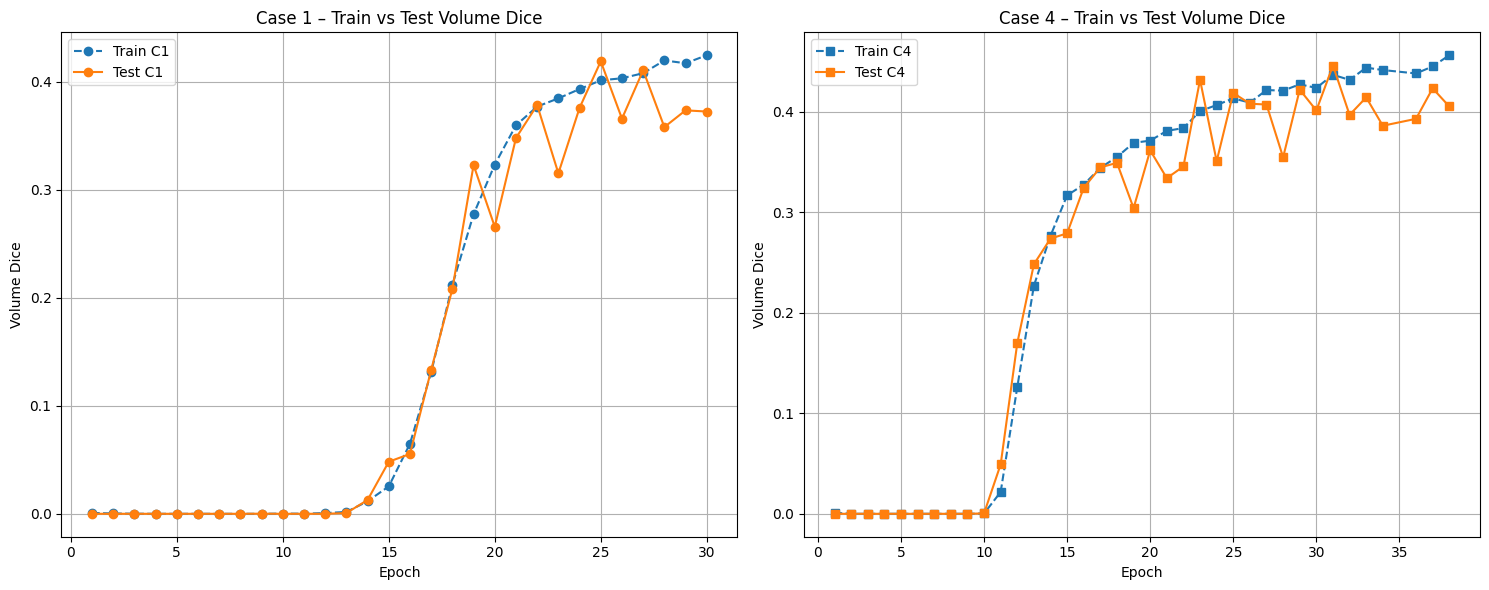

In [34]:
import matplotlib.pyplot as plt

# -------------------------
# Extract epochs
# -------------------------
epochs_1 = [log["epoch"] for log in training_log_1]
epochs_4 = [log["epoch"] for log in training_log_4]

# -------------------------
# Extract Volume Dice values
# -------------------------
train_vol_1 = [log["train_vol_dice"] for log in training_log_1]
test_vol_1  = [log["test_vol_dice"]  for log in training_log_1]

train_vol_4 = [log["train_vol_dice"] for log in training_log_4]
test_vol_4  = [log["test_vol_dice"]  for log in training_log_4]

# -------------------------
# PLOT VOLUME DICE FOR BOTH CASES SIDE BY SIDE
# -------------------------
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Case 1
axs[0].plot(epochs_1, train_vol_1, '--o', label="Train C1")
axs[0].plot(epochs_1, test_vol_1, '-o', label="Test C1")
axs[0].set_title("Case 1 – Train vs Test Volume Dice")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Volume Dice")
axs[0].grid(True)
axs[0].legend()

# Case 4
axs[1].plot(epochs_4, train_vol_4, '--s', label="Train C4")
axs[1].plot(epochs_4, test_vol_4, '-s', label="Test C4")
axs[1].set_title("Case 4 – Train vs Test Volume Dice")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Volume Dice")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

In [37]:
# ------------------------------
# Additive  attention case 1 with Surface Dice
# ------------------------------
training_log_1 = [
    {"epoch": 1,  "train_loss": 0.0395, "test_loss": 0.0243, "train_vol_dice": 0.0008, "test_vol_dice": 0.0000, "train_surf_dice": 0.0007, "test_surf_dice": 0.0000},
    {"epoch": 2,  "train_loss": 0.0145, "test_loss": 0.0101, "train_vol_dice": 0.0003, "test_vol_dice": 0.0000, "train_surf_dice": 0.0001, "test_surf_dice": 0.0000},
    {"epoch": 3,  "train_loss": 0.0081, "test_loss": 0.0064, "train_vol_dice": 0.0001, "test_vol_dice": 0.0000, "train_surf_dice": 0.0001, "test_surf_dice": 0.0000},
    {"epoch": 4,  "train_loss": 0.0054, "test_loss": 0.0044, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 5,  "train_loss": 0.0036, "test_loss": 0.0030, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 6,  "train_loss": 0.0025, "test_loss": 0.0020, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 7,  "train_loss": 0.0019, "test_loss": 0.0017, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 8,  "train_loss": 0.0014, "test_loss": 0.0012, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 9,  "train_loss": 0.0011, "test_loss": 0.0010, "train_vol_dice": 0.0000, "test_vol_dice": 0.0001, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 10, "train_loss": 0.0009, "test_loss": 0.0008, "train_vol_dice": 0.0002, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 11, "train_loss": 0.0007, "test_loss": 0.0007, "train_vol_dice": 0.0001, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 12, "train_loss": 0.0006, "test_loss": 0.0006, "train_vol_dice": 0.0007, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 13, "train_loss": 0.0005, "test_loss": 0.0004, "train_vol_dice": 0.0017, "test_vol_dice": 0.0007, "train_surf_dice": 0.0002, "test_surf_dice": 0.0002},
    {"epoch": 14, "train_loss": 0.0004, "test_loss": 0.0004, "train_vol_dice": 0.0116, "test_vol_dice": 0.0128, "train_surf_dice": 0.0012, "test_surf_dice": 0.0012},
    {"epoch": 15, "train_loss": 0.0003, "test_loss": 0.0003, "train_vol_dice": 0.0254, "test_vol_dice": 0.0482, "train_surf_dice": 0.0039, "test_surf_dice": 0.0097},
    {"epoch": 16, "train_loss": 0.0003, "test_loss": 0.0003, "train_vol_dice": 0.0649, "test_vol_dice": 0.0554, "train_surf_dice": 0.0137, "test_surf_dice": 0.0132},
    {"epoch": 17, "train_loss": 0.0003, "test_loss": 0.0002, "train_vol_dice": 0.1311, "test_vol_dice": 0.1332, "train_surf_dice": 0.0356, "test_surf_dice": 0.0407},
    {"epoch": 18, "train_loss": 0.0002, "test_loss": 0.0002, "train_vol_dice": 0.2119, "test_vol_dice": 0.2082, "train_surf_dice": 0.0753, "test_surf_dice": 0.0807},
    {"epoch": 19, "train_loss": 0.0002, "test_loss": 0.0002, "train_vol_dice": 0.2773, "test_vol_dice": 0.3228, "train_surf_dice": 0.1194, "test_surf_dice": 0.1668},
    {"epoch": 20, "train_loss": 0.0002, "test_loss": 0.0002, "train_vol_dice": 0.3233, "test_vol_dice": 0.2657, "train_surf_dice": 0.1569, "test_surf_dice": 0.1209},
    {"epoch": 21, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.3579, "test_vol_dice": 0.3390, "train_surf_dice": 0.1904, "test_surf_dice": 0.1955},
   {"epoch": 22, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.3749, "test_vol_dice": 0.3716, "train_surf_dice": 0.2067, "test_surf_dice": 0.2101},
    {"epoch": 23, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.3861, "test_vol_dice": 0.3542, "train_surf_dice": 0.2161, "test_surf_dice": 0.1919},
    {"epoch": 24, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.3943, "test_vol_dice": 0.3805, "train_surf_dice": 0.2233, "test_surf_dice": 0.2202},
    {"epoch": 25, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.4023, "test_vol_dice": 0.3959, "train_surf_dice": 0.2311, "test_surf_dice": 0.2319}
]

best_volume_dice_1 = 0.3959
best_surface_dice_1 = 0.2319

# ------------------------------
# Multiplicative attention case 2 with Surface Dice
# ------------------------------
training_log_2 = [
    {"epoch": 1,  "train_loss": 0.0335, "test_loss": 0.0205, "train_vol_dice": 0.0011, "test_vol_dice": 0.0000, "train_surf_dice": 0.0009, "test_surf_dice": 0.0000},
    {"epoch": 2,  "train_loss": 0.0125, "test_loss": 0.0087, "train_vol_dice": 0.0001, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 3,  "train_loss": 0.0069, "test_loss": 0.0054, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 4,  "train_loss": 0.0044, "test_loss": 0.0033, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 5,  "train_loss": 0.0030, "test_loss": 0.0025, "train_vol_dice": 0.0006, "test_vol_dice": 0.0010, "train_surf_dice": 0.0001, "test_surf_dice": 0.0001},
    {"epoch": 6,  "train_loss": 0.0021, "test_loss": 0.0018, "train_vol_dice": 0.0057, "test_vol_dice": 0.0079, "train_surf_dice": 0.0008, "test_surf_dice": 0.0009},
    {"epoch": 7,  "train_loss": 0.0016, "test_loss": 0.0014, "train_vol_dice": 0.0183, "test_vol_dice": 0.0373, "train_surf_dice": 0.0024, "test_surf_dice": 0.0078},
    {"epoch": 8,  "train_loss": 0.0012, "test_loss": 0.0010, "train_vol_dice": 0.0447, "test_vol_dice": 0.0607, "train_surf_dice": 0.0082, "test_surf_dice": 0.0127},
    {"epoch": 9,  "train_loss": 0.0009, "test_loss": 0.0009, "train_vol_dice": 0.0812, "test_vol_dice": 0.0674, "train_surf_dice": 0.0164, "test_surf_dice": 0.0118},
    {"epoch": 10, "train_loss": 0.0008, "test_loss": 0.0007, "train_vol_dice": 0.1138, "test_vol_dice": 0.0916, "train_surf_dice": 0.0252, "test_surf_dice": 0.0181},
    {"epoch": 11, "train_loss": 0.0006, "test_loss": 0.0006, "train_vol_dice": 0.1464, "test_vol_dice": 0.1696, "train_surf_dice": 0.0388, "test_surf_dice": 0.0559},
    {"epoch": 12, "train_loss": 0.0005, "test_loss": 0.0004, "train_vol_dice": 0.1686, "test_vol_dice": 0.1430, "train_surf_dice": 0.0501, "test_surf_dice": 0.0384},
    {"epoch": 13, "train_loss": 0.0004, "test_loss": 0.0004, "train_vol_dice": 0.1996, "test_vol_dice": 0.2353, "train_surf_dice": 0.0649, "test_surf_dice": 0.0956},
    {"epoch": 14, "train_loss": 0.0003, "test_loss": 0.0003, "train_vol_dice": 0.2218, "test_vol_dice": 0.2120, "train_surf_dice": 0.0776, "test_surf_dice": 0.0749},
    {"epoch": 15, "train_loss": 0.0003, "test_loss": 0.0002, "train_vol_dice": 0.2487, "test_vol_dice": 0.2323, "train_surf_dice": 0.0936, "test_surf_dice": 0.0894},
    {"epoch": 16, "train_loss": 0.0002, "test_loss": 0.0002, "train_vol_dice": 0.2741, "test_vol_dice": 0.2489, "train_surf_dice": 0.1099, "test_surf_dice": 0.0953},
    {"epoch": 17, "train_loss": 0.0002, "test_loss": 0.0002, "train_vol_dice": 0.2901, "test_vol_dice": 0.2850, "train_surf_dice": 0.1247, "test_surf_dice": 0.1363},
    {"epoch": 18, "train_loss": 0.0002, "test_loss": 0.0002, "train_vol_dice": 0.3046, "test_vol_dice": 0.3160, "train_surf_dice": 0.1365, "test_surf_dice": 0.1523},
    {"epoch": 19, "train_loss": 0.0002, "test_loss": 0.0001, "train_vol_dice": 0.3228, "test_vol_dice": 0.3149, "train_surf_dice": 0.1516, "test_surf_dice": 0.1501},
    {"epoch": 20, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.3475, "test_vol_dice": 0.3146, "train_surf_dice": 0.1716, "test_surf_dice": 0.1494},
    {"epoch": 21, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.3653, "test_vol_dice": 0.3669, "train_surf_dice": 0.1852, "test_surf_dice": 0.2231},
    {"epoch": 22, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.3732, "test_vol_dice": 0.3753, "train_surf_dice": 0.1937, "test_surf_dice": 0.2007},
    {"epoch": 23, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.3825, "test_vol_dice": 0.4015, "train_surf_dice": 0.2020, "test_surf_dice": 0.2316},
    {"epoch": 24, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.3909, "test_vol_dice": 0.3555, "train_surf_dice": 0.2084, "test_surf_dice": 0.1871},
    {"epoch": 25, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.3793, "test_vol_dice": 0.3781, "train_surf_dice": 0.2037, "test_surf_dice": 0.2044}
]

best_volume_dice_2 = 0.4015
best_surface_dice_2 = 0.2316

# ------------------------------
# Multiplicative Differential attention case 4 with Surface Dice
# ------------------------------
training_log_3 = [
    {"epoch": 1, "train_loss": 0.0317, "test_loss": 0.0167, "train_vol_dice": 0.0008, "test_vol_dice": 0.0000, "train_surf_dice": 0.0007, "test_surf_dice": 0.0000},
    {"epoch": 2, "train_loss": 0.0122, "test_loss": 0.0092, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 3, "train_loss": 0.0068, "test_loss": 0.0055, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 4, "train_loss": 0.0042, "test_loss": 0.0035, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 5, "train_loss": 0.0028, "test_loss": 0.0027, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 6, "train_loss": 0.0020, "test_loss": 0.0016, "train_vol_dice": 0.0001, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 7, "train_loss": 0.0015, "test_loss": 0.0012, "train_vol_dice": 0.0002, "test_vol_dice": 0.0001, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 8, "train_loss": 0.0011, "test_loss": 0.0009, "train_vol_dice": 0.0042, "test_vol_dice": 0.0144, "train_surf_dice": 0.0004, "test_surf_dice": 0.0017},
    {"epoch": 9, "train_loss": 0.0009, "test_loss": 0.0008, "train_vol_dice": 0.0467, "test_vol_dice": 0.0525, "train_surf_dice": 0.0068, "test_surf_dice": 0.0094},
    {"epoch": 10, "train_loss": 0.0007, "test_loss": 0.0006, "train_vol_dice": 0.0898, "test_vol_dice": 0.0985, "train_surf_dice": 0.0183, "test_surf_dice": 0.0250},
    {"epoch": 11, "train_loss": 0.0005, "test_loss": 0.0005, "train_vol_dice": 0.1224, "test_vol_dice": 0.1132, "train_surf_dice": 0.0322, "test_surf_dice": 0.0301},
    {"epoch": 12, "train_loss": 0.0005, "test_loss": 0.0004, "train_vol_dice": 0.1581, "test_vol_dice": 0.1619, "train_surf_dice": 0.0501, "test_surf_dice": 0.0601},
    {"epoch": 13, "train_loss": 0.0004, "test_loss": 0.0004, "train_vol_dice": 0.1878, "test_vol_dice": 0.2192, "train_surf_dice": 0.0669, "test_surf_dice": 0.0918},
    {"epoch": 14, "train_loss": 0.0003, "test_loss": 0.0003, "train_vol_dice": 0.2279, "test_vol_dice": 0.1985, "train_surf_dice": 0.0882, "test_surf_dice": 0.0755},
    {"epoch": 15, "train_loss": 0.0003, "test_loss": 0.0002, "train_vol_dice": 0.2589, "test_vol_dice": 0.2243, "train_surf_dice": 0.1049, "test_surf_dice": 0.0895},
    {"epoch": 16, "train_loss": 0.0002, "test_loss": 0.0002, "train_vol_dice": 0.2796, "test_vol_dice": 0.3047, "train_surf_dice": 0.1200, "test_surf_dice": 0.1384},
    {"epoch": 17, "train_loss": 0.0002, "test_loss": 0.0002, "train_vol_dice": 0.3072, "test_vol_dice": 0.3007, "train_surf_dice": 0.1368, "test_surf_dice": 0.1416},
    {"epoch": 18, "train_loss": 0.0002, "test_loss": 0.0001, "train_vol_dice": 0.3346, "test_vol_dice": 0.3075, "train_surf_dice": 0.1590, "test_surf_dice": 0.1491},
    {"epoch": 19, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.3523, "test_vol_dice": 0.3776, "train_surf_dice": 0.1743, "test_surf_dice": 0.2045},
    {"epoch": 20, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.3596, "test_vol_dice": 0.3691, "train_surf_dice": 0.1808, "test_surf_dice": 0.1949},
    {"epoch": 21, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.3678, "test_vol_dice": 0.3490, "train_surf_dice": 0.1874, "test_surf_dice": 0.1983},
    {"epoch": 22, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.3714, "test_vol_dice": 0.3395, "train_surf_dice": 0.1919, "test_surf_dice": 0.1729},
    {"epoch": 23, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.3828, "test_vol_dice": 0.3495, "train_surf_dice": 0.1999, "test_surf_dice": 0.1808},
    {"epoch": 24, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.4005, "test_vol_dice": 0.3212, "train_surf_dice": 0.2142, "test_surf_dice": 0.1615},
    {"epoch": 25, "train_loss": 0.0001, "test_loss": 0.0001, "train_vol_dice": 0.3934, "test_vol_dice": 0.3783, "train_surf_dice": 0.2124, "test_surf_dice": 0.2085}
]

best_volume_dice_3 = 0.3783
best_surface_dice_3 = 0.20849



# ------------------------------
# Additive Differential attention case 4 with Surface Dice
# ------------------------------
training_log_4 = [
    {"epoch": 1, "train_loss": 0.027862, "test_loss": 0.014293, "train_vol_dice": 0.0010, "test_vol_dice": 0.0000, "train_surf_dice": 0.0009, "test_surf_dice": 0.0000},
    {"epoch": 2, "train_loss": 0.010137, "test_loss": 0.006987, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 3, "train_loss": 0.005928, "test_loss": 0.004894, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 4, "train_loss": 0.003742, "test_loss": 0.003034, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 5, "train_loss": 0.002582, "test_loss": 0.002175, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 6, "train_loss": 0.001866, "test_loss": 0.001597, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 7, "train_loss": 0.001414, "test_loss": 0.001421, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 8, "train_loss": 0.001090, "test_loss": 0.000905, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 9, "train_loss": 0.000900, "test_loss": 0.000797, "train_vol_dice": 0.0000, "test_vol_dice": 0.0000, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 10, "train_loss": 0.000684, "test_loss": 0.000650, "train_vol_dice": 0.0003, "test_vol_dice": 0.0004, "train_surf_dice": 0.0000, "test_surf_dice": 0.0000},
    {"epoch": 11, "train_loss": 0.000556, "test_loss": 0.000479, "train_vol_dice": 0.0217, "test_vol_dice": 0.0491, "train_surf_dice": 0.0019, "test_surf_dice": 0.0050},
    {"epoch": 12, "train_loss": 0.000460, "test_loss": 0.000446, "train_vol_dice": 0.1260, "test_vol_dice": 0.1697, "train_surf_dice": 0.0272, "test_surf_dice": 0.0501},
    {"epoch": 13, "train_loss": 0.000380, "test_loss": 0.000373, "train_vol_dice": 0.2268, "test_vol_dice": 0.2482, "train_surf_dice": 0.0799, "test_surf_dice": 0.0994},
    {"epoch": 14, "train_loss": 0.000320, "test_loss": 0.000298, "train_vol_dice": 0.2765, "test_vol_dice": 0.2737, "train_surf_dice": 0.1143, "test_surf_dice": 0.1248},
    {"epoch": 15, "train_loss": 0.000269, "test_loss": 0.000249, "train_vol_dice": 0.3167, "test_vol_dice": 0.2789, "train_surf_dice": 0.1416, "test_surf_dice": 0.1250},
    {"epoch": 16, "train_loss": 0.000231, "test_loss": 0.000220, "train_vol_dice": 0.3273, "test_vol_dice": 0.3242, "train_surf_dice": 0.1525, "test_surf_dice": 0.1464},
    {"epoch": 17, "train_loss": 0.000194, "test_loss": 0.000160, "train_vol_dice": 0.3441, "test_vol_dice": 0.3445, "train_surf_dice": 0.1633, "test_surf_dice": 0.1793},
    {"epoch": 18, "train_loss": 0.000166, "test_loss": 0.000175, "train_vol_dice": 0.3548, "test_vol_dice": 0.3490, "train_surf_dice": 0.1742, "test_surf_dice": 0.1792},
    {"epoch": 19, "train_loss": 0.000143, "test_loss": 0.000138, "train_vol_dice": 0.3689, "test_vol_dice": 0.3040, "train_surf_dice": 0.1858, "test_surf_dice": 0.1434},
    {"epoch": 20, "train_loss": 0.000124, "test_loss": 0.000111, "train_vol_dice": 0.3711, "test_vol_dice": 0.3614, "train_surf_dice": 0.1892, "test_surf_dice": 0.1844},
    {"epoch": 21, "train_loss": 0.000109, "test_loss": 0.000102, "train_vol_dice": 0.3808, "test_vol_dice": 0.3338, "train_surf_dice": 0.1993, "test_surf_dice": 0.1711},
    {"epoch": 22, "train_loss": 0.000096, "test_loss": 0.000092, "train_vol_dice": 0.3836, "test_vol_dice": 0.3454, "train_surf_dice": 0.2018, "test_surf_dice": 0.1678},
    {"epoch": 23, "train_loss": 0.000083, "test_loss": 0.000087, "train_vol_dice": 0.4004, "test_vol_dice": 0.4316, "train_surf_dice": 0.2172, "test_surf_dice": 0.2593},
    {"epoch": 24, "train_loss": 0.000072, "test_loss": 0.000067, "train_vol_dice": 0.4065, "test_vol_dice": 0.3506, "train_surf_dice": 0.2239, "test_surf_dice": 0.1828},
    {"epoch": 25, "train_loss": 0.000064, "test_loss": 0.000067, "train_vol_dice": 0.4131, "test_vol_dice": 0.4185, "train_surf_dice": 0.2313, "test_surf_dice": 0.2454}
]
best_volume_dice_4 = 0.4316
best_surface_dice_4 = 0.2593


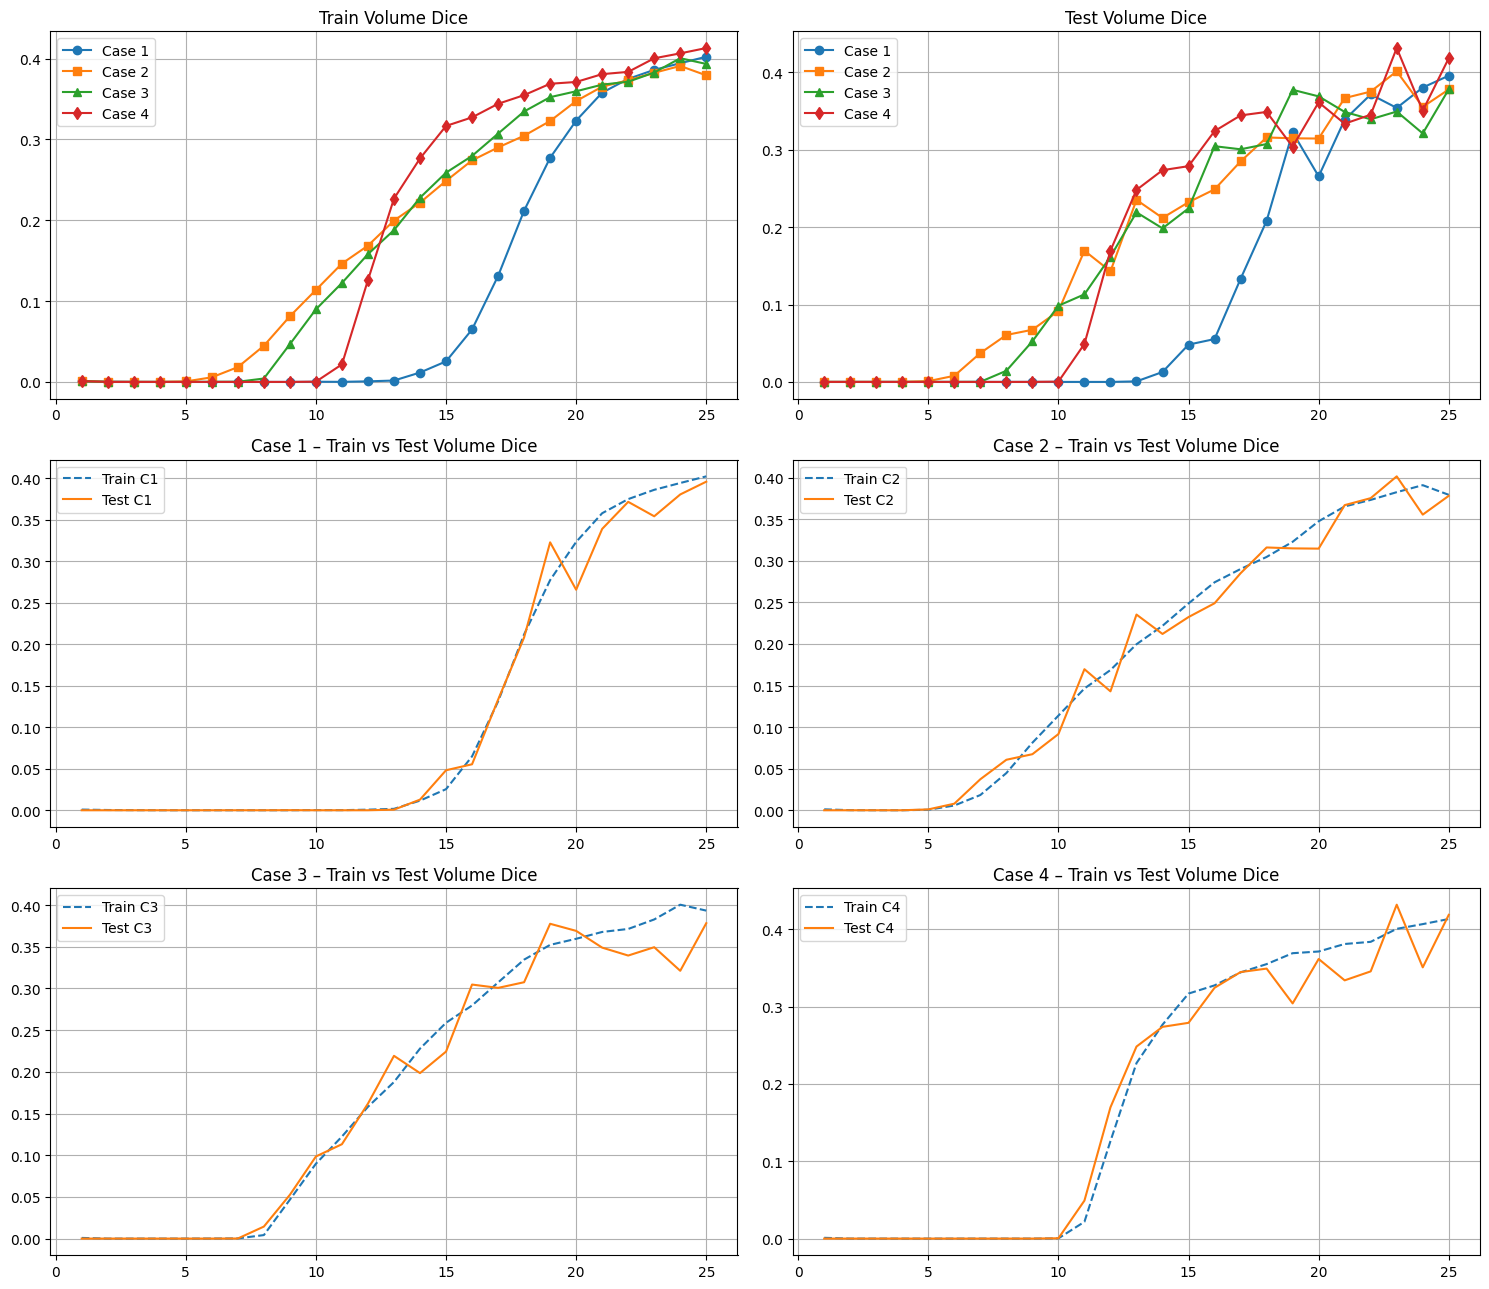

In [38]:
import matplotlib.pyplot as plt

# -------------------------
# Extract epochs from any case (all have same length)
# -------------------------
epochs = [log["epoch"] for log in training_log_1]

# -------------------------
# Extract Volume Dice values
# -------------------------
train_vol_1 = [log["train_vol_dice"] for log in training_log_1]
test_vol_1  = [log["test_vol_dice"]  for log in training_log_1]

train_vol_2 = [log["train_vol_dice"] for log in training_log_2]
test_vol_2  = [log["test_vol_dice"]  for log in training_log_2]

train_vol_3 = [log["train_vol_dice"] for log in training_log_3]
test_vol_3  = [log["test_vol_dice"]  for log in training_log_3]

train_vol_4 = [log["train_vol_dice"] for log in training_log_4]
test_vol_4  = [log["test_vol_dice"]  for log in training_log_4]

# -------------------------
# PLOT VOLUME DICE
# -------------------------
fig, axs = plt.subplots(3, 2, figsize=(15, 13))
axs = axs.ravel()

# 1. Train Volume Dice
axs[0].plot(epochs, train_vol_1, label="Case 1", marker="o")
axs[0].plot(epochs, train_vol_2, label="Case 2", marker="s")
axs[0].plot(epochs, train_vol_3, label="Case 3", marker="^")
axs[0].plot(epochs, train_vol_4, label="Case 4", marker="d")
axs[0].set_title("Train Volume Dice")
axs[0].grid(True)
axs[0].legend()

# 2. Test Volume Dice
axs[1].plot(epochs, test_vol_1, label="Case 1", marker="o")
axs[1].plot(epochs, test_vol_2, label="Case 2", marker="s")
axs[1].plot(epochs, test_vol_3, label="Case 3", marker="^")
axs[1].plot(epochs, test_vol_4, label="Case 4", marker="d")
axs[1].set_title("Test Volume Dice")
axs[1].grid(True)
axs[1].legend()

# 3. Train vs Test (Case 1)
axs[2].plot(epochs, train_vol_1, '--', label="Train C1")
axs[2].plot(epochs, test_vol_1, label="Test C1")
axs[2].set_title("Case 1 – Train vs Test Volume Dice")
axs[2].grid(True)
axs[2].legend()

# 4. Case 2
axs[3].plot(epochs, train_vol_2, '--', label="Train C2")
axs[3].plot(epochs, test_vol_2, label="Test C2")
axs[3].set_title("Case 2 – Train vs Test Volume Dice")
axs[3].grid(True)
axs[3].legend()

# 5. Case 3
axs[4].plot(epochs, train_vol_3, '--', label="Train C3")
axs[4].plot(epochs, test_vol_3, label="Test C3")
axs[4].set_title("Case 3 – Train vs Test Volume Dice")
axs[4].grid(True)
axs[4].legend()

# 6. Case 4
axs[5].plot(epochs, train_vol_4, '--', label="Train C4")
axs[5].plot(epochs, test_vol_4, label="Test C4")
axs[5].set_title("Case 4 – Train vs Test Volume Dice")
axs[5].grid(True)
axs[5].legend()

plt.tight_layout()
plt.show()



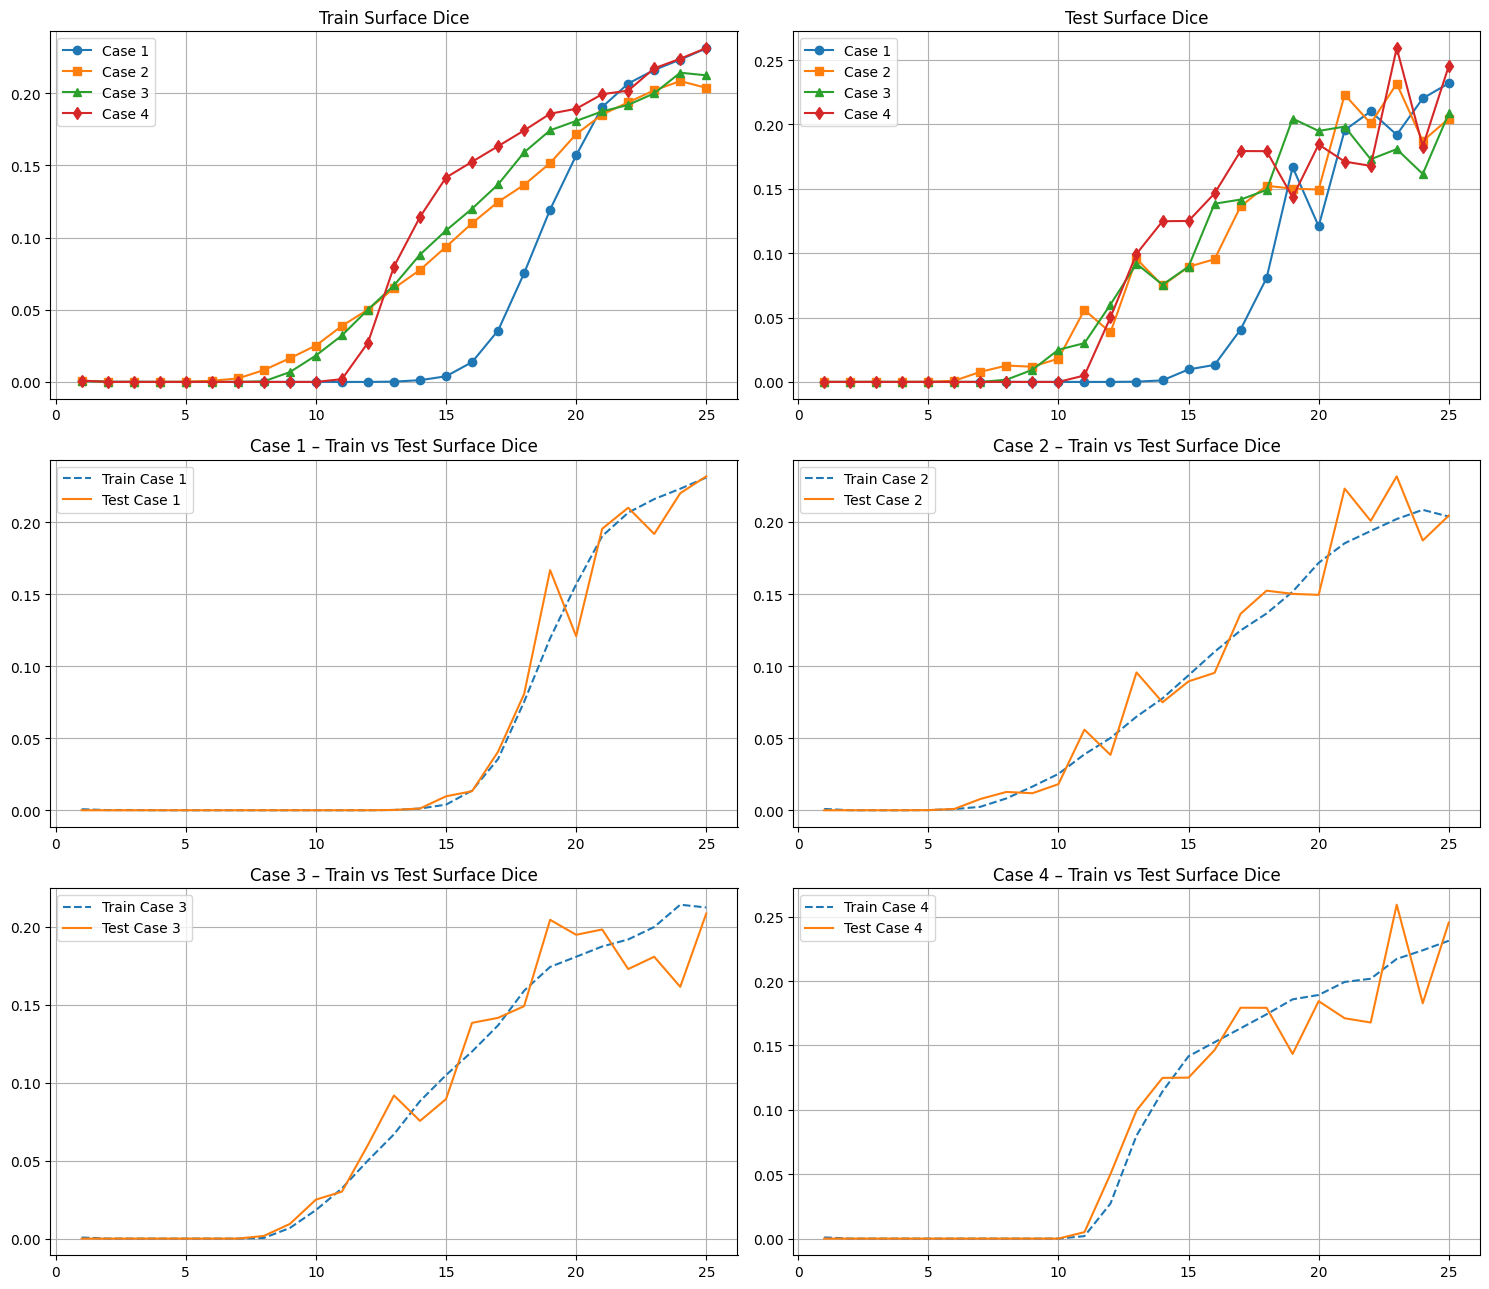

In [39]:
# -------------------------
# Extract Surface Dice values
# -------------------------
train_surf_1 = [log["train_surf_dice"] for log in training_log_1]
test_surf_1  = [log["test_surf_dice"]  for log in training_log_1]

train_surf_2 = [log["train_surf_dice"] for log in training_log_2]
test_surf_2  = [log["test_surf_dice"]  for log in training_log_2]

train_surf_3 = [log["train_surf_dice"] for log in training_log_3]
test_surf_3  = [log["test_surf_dice"]  for log in training_log_3]

train_surf_4 = [log["train_surf_dice"] for log in training_log_4]
test_surf_4  = [log["test_surf_dice"]  for log in training_log_4]

# -------------------------
# PLOT SURFACE DICE
# -------------------------
fig, axs = plt.subplots(3, 2, figsize=(15, 13))
axs = axs.ravel()

# 1. Train Surface Dice
axs[0].plot(epochs, train_surf_1, label="Case 1", marker="o")
axs[0].plot(epochs, train_surf_2, label="Case 2", marker="s")
axs[0].plot(epochs, train_surf_3, label="Case 3", marker="^")
axs[0].plot(epochs, train_surf_4, label="Case 4", marker="d")
axs[0].set_title("Train Surface Dice")
axs[0].grid(True)
axs[0].legend()

# 2. Test Surface Dice
axs[1].plot(epochs, test_surf_1, label="Case 1", marker="o")
axs[1].plot(epochs, test_surf_2, label="Case 2", marker="s")
axs[1].plot(epochs, test_surf_3, label="Case 3", marker="^")
axs[1].plot(epochs, test_surf_4, label="Case 4", marker="d")
axs[1].set_title("Test Surface Dice")
axs[1].grid(True)
axs[1].legend()

# 3–6 Train vs Test per case
cases = [
    ("Case 1", train_surf_1, test_surf_1),
    ("Case 2", train_surf_2, test_surf_2),
    ("Case 3", train_surf_3, test_surf_3),
    ("Case 4", train_surf_4, test_surf_4),
]

for i, (name, tr, te) in enumerate(cases, start=2):
    axs[i].plot(epochs, tr, "--", label=f"Train {name}")
    axs[i].plot(epochs, te, label=f"Test {name}")
    axs[i].set_title(f"{name} – Train vs Test Surface Dice")
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()


Additive attention is better because it can model non-linear interactions, handle different dimensions flexibly, and empirically achieves higher accuracy, at the cost of slightly higher computation. The differential attention also provides better empirical results on the data where the test dice (both surface and volume) reachs higher values and saturate for larger epochs. This principle is directly applied in Attention U-Net to improve segmentation performance. 

In [25]:
import os
os.listdir('/kaggle/input/model-case4-epoch40')

['trained_model.pth']

In [36]:
model = AttentionUNet()   # same architecture you used in training

model.load_state_dict(
    torch.load('/kaggle/input/model-case4-epoch40/trained_model.pth', map_location='cpu')
)

model.eval()

AttentionUNet(
  (MaxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)

In [77]:
# put here the idex of the kidney image you want to analyse
KIDNEY_NUMBER = 600

Raw min: -5.338273048400879
Raw max: 3.9536263942718506
Sigmoid min: 0.004781190771609545
Sigmoid max: 0.9811761975288391
Sigmoid mean: 0.02124512754380703


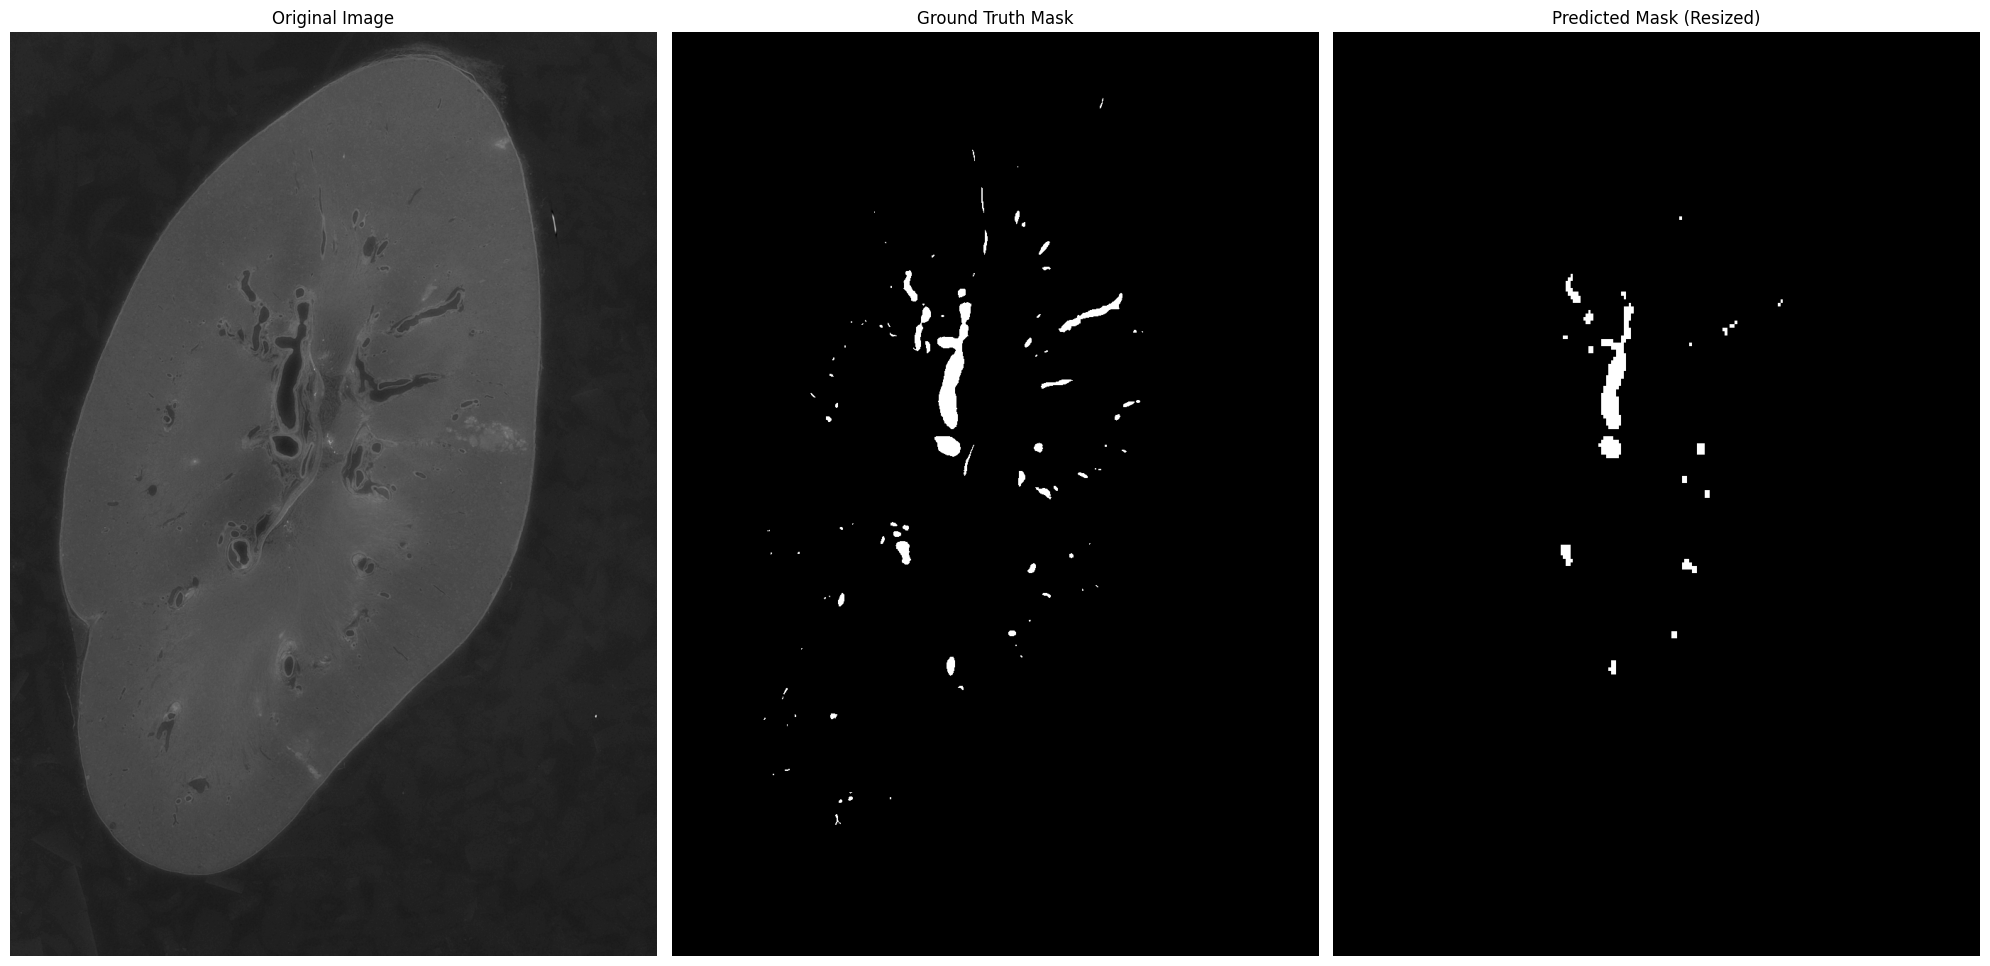

===== Segmentation Metrics =====
Dice score:      0.6132
IoU:             0.4421
Precision:       0.8070
Recall:          0.4944

===== Confusion Matrix =====
TN: 1177204
FP: 1177
FN: 5033
TP: 4922


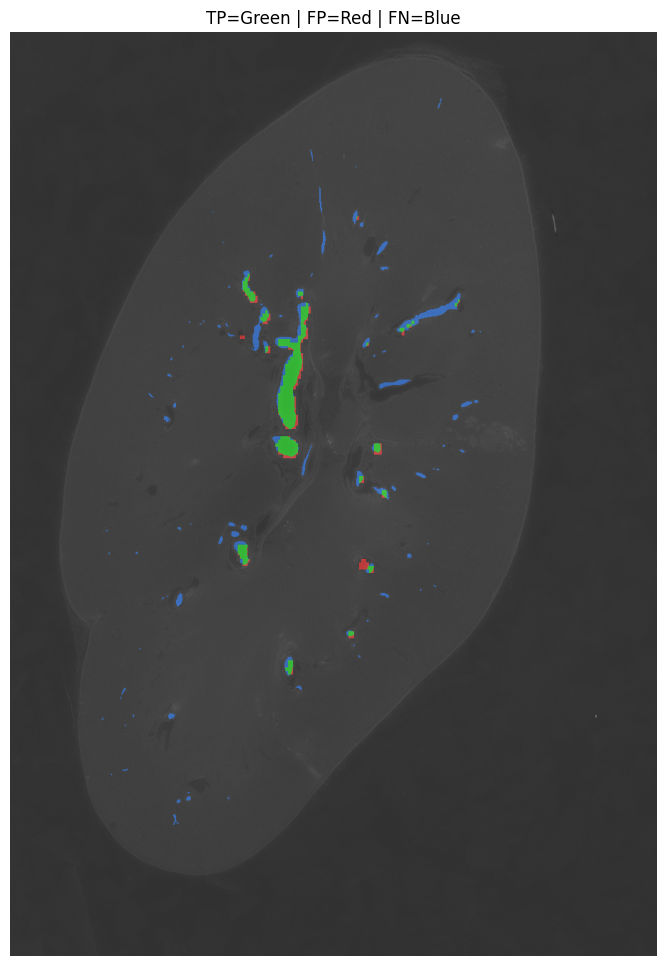

Number of vessel regions (ground truth): 96
Number of vessel regions (predicted): 21
Mean FN per region: 0.9186
Max FN per region: 1.0000
Min FN per region: 0.1453


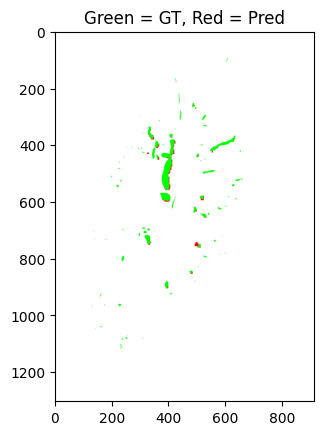

Number of ground truth vessels: 96
       region_id  size_pixels   fn_pixels  fn_fraction  mean_fn_prob
count  96.000000    96.000000   96.000000    96.000000     96.000000
mean   48.500000   103.697917   52.427083     0.918594      0.108356
std    27.856777   379.382410  116.824272     0.212266      0.106885
min     1.000000     2.000000    2.000000     0.145266      0.011976
25%    24.750000     6.000000    6.000000     1.000000      0.022430
50%    48.500000    17.000000   17.000000     1.000000      0.063241
75%    72.250000    66.500000   50.750000     1.000000      0.191096
max    96.000000  3493.000000  840.000000     1.000000      0.393230


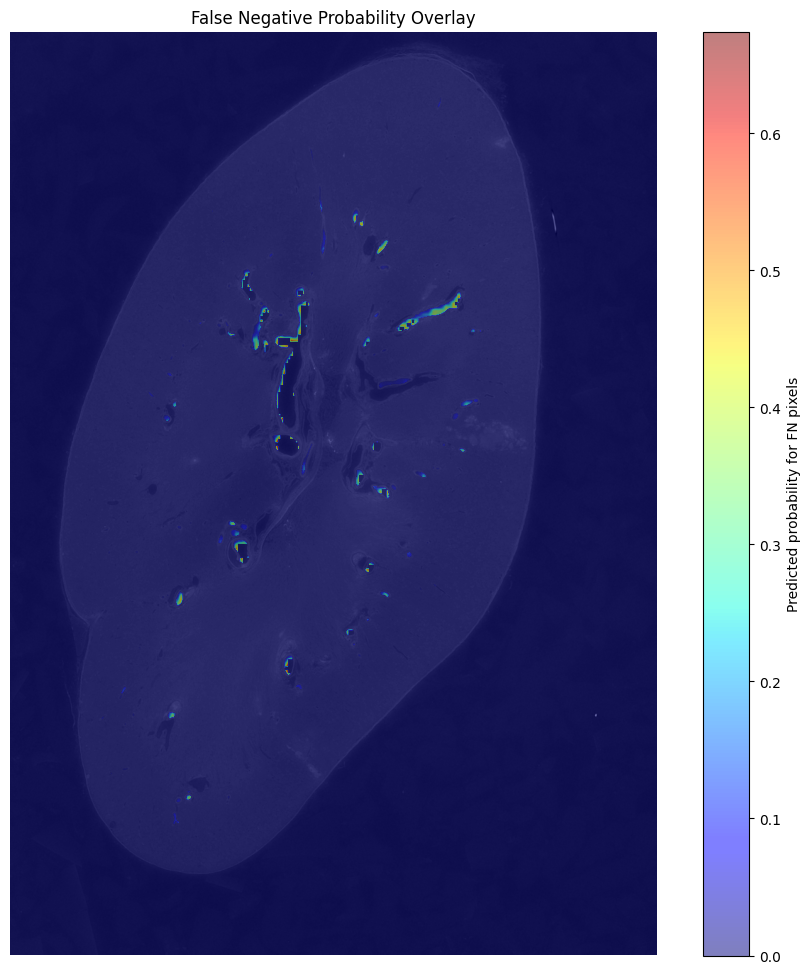

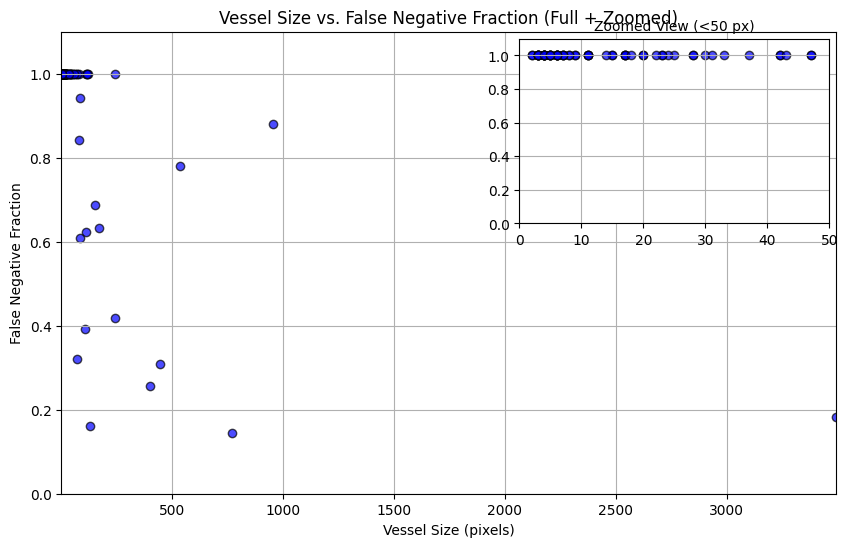

Ratio of FN vessels among all vessels: 0.7083


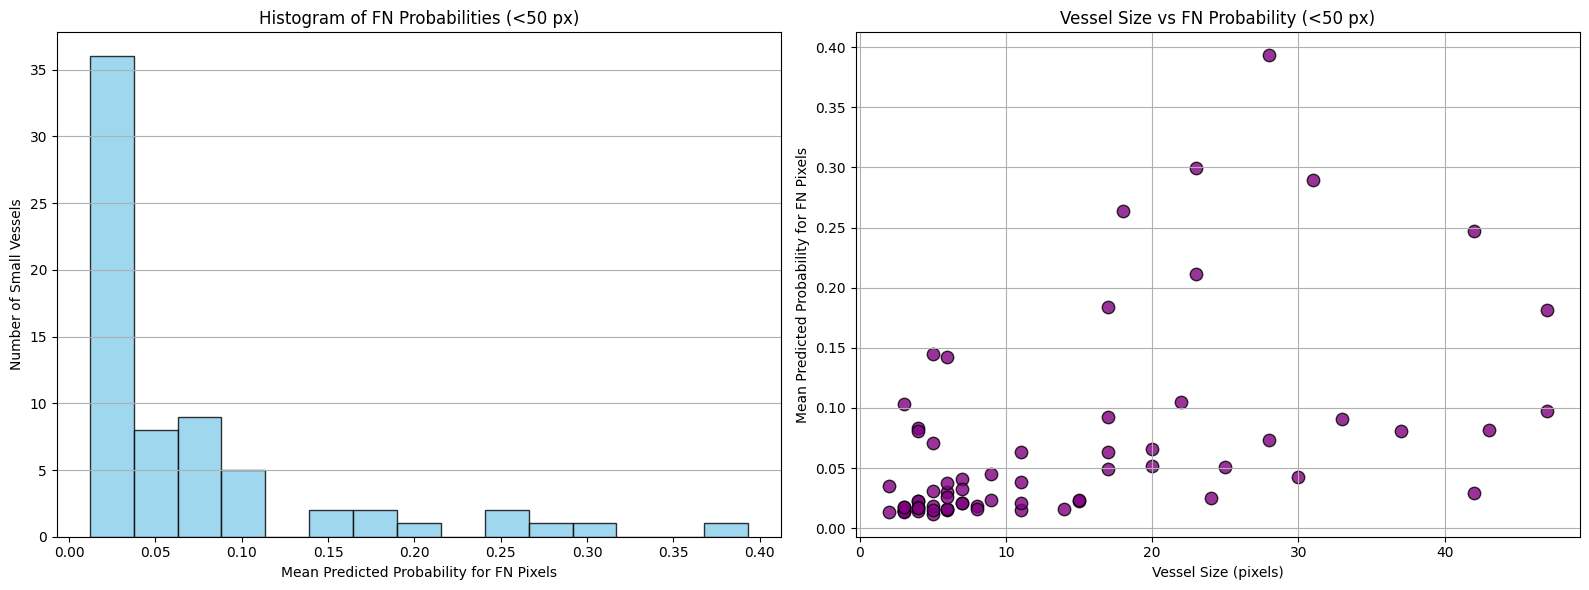

Number of small vessels: 68
Mean probability: 0.0674
Median probability: 0.0315
Max probability: 0.3932
Min probability: 0.0120
Number of tiny vessels (<=10 px): 38
Mean predicted probability for tiny vessels: 0.0345
Median predicted probability for tiny vessels: 0.0197
Min probability: 0.0120, Max probability: 0.1452


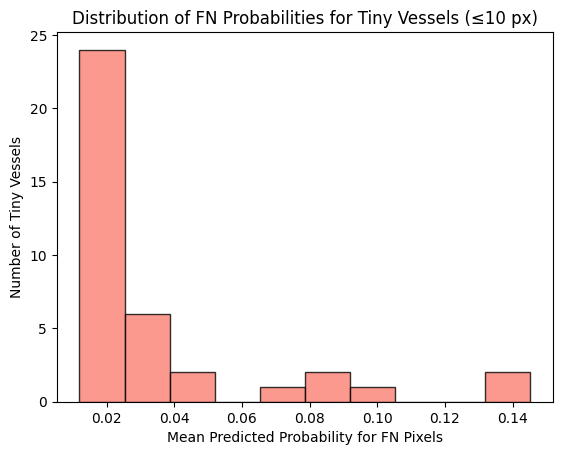

===== Metrics ignoring vessels <50px =====
Dice score:      0.6509
IoU:             0.4825
Precision:       0.8070
Recall:          0.5454
TN: 1178134 FP: 1177 FN: 4103 TP: 4922
Volumetric Dice: 0.6509
Surface Dice (tolerance 1px): 1.0215
Surface Dice (tolerance 0px): 1.0000


In [78]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import albumentations as A
import tifffile as tiff
import cv2



# --------------------------------------------------
# 0️⃣ Same preprocess functions used in training
# --------------------------------------------------
def preprocess_image(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = np.tile(img[..., None], [1, 1, 3])  # HWC → 3 channels
    img = img.astype('float32')
    mx = np.max(img)
    if mx > 0:
        img /= mx
    img = np.transpose(img, (2, 0, 1))  # CHW
    return torch.tensor(img, dtype=torch.float32)

def preprocess_mask(path):
    msk = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    msk = msk.astype('float32') / 255.0
    return torch.tensor(msk, dtype=torch.float32)

# --------------------------------------------------
# 1️⃣ INFERENCE TRANSFORM (Resize only)
# --------------------------------------------------
def inference_resize(image, mask):
    # Convert to numpy HWC + HW
    image_np = image.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()

    transform = A.Compose([
        A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)
    ])

    aug = transform(image=image_np, mask=mask_np)

    image_out = torch.tensor(aug["image"], dtype=torch.float32).permute(2, 0, 1)
    mask_out  = torch.tensor(aug["mask"],  dtype=torch.float32)

    return image_out, mask_out


# --------------------------------------------------
# 2️⃣ CustomDataset (same as training)
# --------------------------------------------------
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, mask_files, input_size=(256, 256), augmentation_transforms=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.input_size = input_size
        self.augmentation_transforms = augmentation_transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img = preprocess_image(self.image_files[idx])
        msk = preprocess_mask(self.mask_files[idx])

        if self.augmentation_transforms:
            img, msk = self.augmentation_transforms(img, msk)

        return img, msk


# --------------------------------------------------
# 3️⃣ Load your trained model
# --------------------------------------------------
model = AttentionUNet()
model.load_state_dict(
    torch.load('/kaggle/input/model-case4-epoch40/trained_model.pth', map_location="cpu")
)
model.eval()


# --------------------------------------------------
# 4️⃣ Load ONE IMAGE
# --------------------------------------------------
base_path = "/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense"
images_path = base_path + "/images"
labels_path = base_path + "/labels"

image_files = sorted([os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith(".tif")])
label_files = sorted([os.path.join(labels_path, f) for f in os.listdir(labels_path) if f.endswith(".tif")])

idx = KIDNEY_NUMBER

inference_dataset = CustomDataset(
    [image_files[idx]],
    [label_files[idx]],
    augmentation_transforms=inference_resize  # <-- now correct!
)

inference_loader = DataLoader(inference_dataset, batch_size=1, shuffle=False)


# --------------------------------------------------
# 5️⃣ Run inference
# --------------------------------------------------
with torch.no_grad():
    for batch_images, batch_masks in inference_loader:

        pred = model(batch_images)
        pred_sigmoid = torch.sigmoid(pred)

        print("Raw min:", pred.min().item())
        print("Raw max:", pred.max().item())
        print("Sigmoid min:", pred_sigmoid.min().item())
        print("Sigmoid max:", pred_sigmoid.max().item())
        print("Sigmoid mean:", pred_sigmoid.mean().item())

        pred_mask = (pred_sigmoid > 0.5).float()
        pred_mask_np = pred_mask.squeeze().cpu().numpy()
        break


# --------------------------------------------------
# 6️⃣ Display results (including ground truth)
# --------------------------------------------------

# --------------------------------------------------
# Resize predicted mask back to original size
# --------------------------------------------------
original_image = tiff.imread(image_files[idx])
ground_truth_mask = preprocess_mask(label_files[idx]).numpy()

# Resize prediction to original size
from PIL import Image
pred_resized = np.array(
    Image.fromarray(pred_mask_np.astype(np.uint8)).resize(
        (original_image.shape[1], original_image.shape[0]),
        resample=Image.NEAREST
    )
)

# --------------------------------------------------
# Show all 3 images
# --------------------------------------------------
def show_images(images, titles=None, cmap='gray'):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(20, 10))
    if not isinstance(axes, np.ndarray):
        axes = [axes]
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap=cmap)
        if titles:
            ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_images(
    [original_image, ground_truth_mask, pred_resized],
    titles=["Original Image", "Ground Truth Mask", "Predicted Mask (Resized)"]
)

# --------------------------------------------------
# metric analysis 
# --------------------------------------------------
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Ground truth & prediction
true_mask_np = ground_truth_mask
pred_mask_np = pred_resized

# Flatten masks (required for sklearn)
y_true = true_mask_np.flatten()
y_pred = pred_mask_np.flatten()

# Ensure binary (0 or 1)
y_true = (y_true > 0.5).astype(np.uint8)
y_pred = (y_pred > 0.5).astype(np.uint8)

# ---- METRICS ----
dice = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

# IoU
intersection = np.logical_and(y_true, y_pred).sum()
union = np.logical_or(y_true, y_pred).sum()
iou = intersection / union if union != 0 else 0.0

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print("===== Segmentation Metrics =====")
print(f"Dice score:      {dice:.4f}")
print(f"IoU:             {iou:.4f}")
print(f"Precision:       {precision:.4f}")
print(f"Recall:          {recall:.4f}")

print("\n===== Confusion Matrix =====")
print("TN:", tn)
print("FP:", fp)
print("FN:", fn)
print("TP:", tp)

# Flattened arrays (already computed)
# y_true = ground truth mask, y_pred = predicted mask
y_true = ground_truth_mask.flatten() > 0.5
y_pred = pred_resized.flatten() > 0.5

# Reshape back to original mask shape
H, W = ground_truth_mask.shape
y_true_2d = y_true.reshape(H, W)
y_pred_2d = y_pred.reshape(H, W)

# Compute TP, FP, FN
TP = np.logical_and(y_pred_2d, y_true_2d)
FP = np.logical_and(y_pred_2d, np.logical_not(y_true_2d))
FN = np.logical_and(np.logical_not(y_pred_2d), y_true_2d)

# Create overlay image (3-channel RGB)
overlay = np.zeros((H, W, 3), dtype=np.uint8)

# Color coding: TP=green, FP=red, FN=blue
overlay[TP] = [0, 255, 0]    # green
overlay[FP] = [255, 0, 0]    # red
overlay[FN] = [0, 100, 255]    # blue

# Original image in 0-255 range (grayscale → RGB)
if len(original_image.shape) == 2:
    original_rgb = np.stack([original_image]*3, axis=-1)
else:
    original_rgb = original_image

original_rgb = (original_rgb / np.max(original_rgb) * 255).astype(np.uint8)

# Blend overlay with original image
alpha = 0.5
blended = ((1-alpha)*original_rgb + alpha*overlay).astype(np.uint8)

# Show result
plt.figure(figsize=(12,12))
plt.imshow(blended)
plt.title("TP=Green | FP=Red | FN=Blue")
plt.axis('off')
plt.show()

from scipy import ndimage

# Flattened binary masks (or keep 2D for labeling)
y_true_2d = y_true.reshape(original_image.shape[:2])
y_pred_2d = y_pred.reshape(original_image.shape[:2])

# Label connected components
gt_labels, num_gt = ndimage.label(y_true_2d)
pred_labels, num_pred = ndimage.label(y_pred_2d)

print(f"Number of vessel regions (ground truth): {num_gt}")
print(f"Number of vessel regions (predicted): {num_pred}")

# Compute false negative per ground-truth region
false_negatives_per_region = []
for region_id in range(1, num_gt+1):
    region_mask = (gt_labels == region_id)
    fn_ratio = 1 - (y_pred_2d[region_mask].sum() / region_mask.sum())
    false_negatives_per_region.append(fn_ratio)

false_negatives_per_region = np.array(false_negatives_per_region)
print(f"Mean FN per region: {false_negatives_per_region.mean():.4f}")
print(f"Max FN per region: {false_negatives_per_region.max():.4f}")
print(f"Min FN per region: {false_negatives_per_region.min():.4f}")

overlay = np.stack([original_image, original_image, original_image], axis=-1)
overlay[y_pred_2d>0] = [255,0,0]   # red predicted vessels
overlay[y_true_2d>0] = [0,255,0]   # green ground truth
plt.imshow(overlay)
plt.title("Green = GT, Red = Pred")
plt.show()

# --------------------------------------------------
# 7️⃣ Per-vessel analysis with FN probabilities
# --------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage
from PIL import Image

def vessel_analysis(original_image, y_true, y_pred, pred_probs):
    """
    Analyze vessel segmentation per region and visualize false negatives.

    Args:
        original_image (H,W) or (H,W,3): original grayscale or RGB image
        y_true (H,W): ground truth binary mask
        y_pred (H,W): predicted binary mask (thresholded)
        pred_probs (H,W): predicted probabilities (sigmoid output)
    """

    # Ensure pred_probs is same size as y_true
    if pred_probs.shape != y_true.shape:
        pred_probs = np.array(
            Image.fromarray(pred_probs).resize(
                (y_true.shape[1], y_true.shape[0]), resample=Image.BILINEAR
            )
        )

    # Label ground truth vessels using ndimage
    gt_labels, num_vessels = ndimage.label(y_true)
    print(f"Number of ground truth vessels: {num_vessels}")

    results = []

    fn_mask = np.logical_and(y_true == 1, y_pred == 0)

    # Per-vessel analysis
    for region_id in range(1, num_vessels + 1):
        region_mask = (gt_labels == region_id)
        fn_pixels = np.logical_and(region_mask, y_pred == 0)
        num_pixels = region_mask.sum()
        fn_frac = fn_pixels.sum() / num_pixels
        fn_prob_mean = pred_probs[fn_pixels].mean() if fn_pixels.sum() > 0 else 0.0

        results.append({
            'region_id': region_id,
            'size_pixels': num_pixels,
            'fn_pixels': fn_pixels.sum(),
            'fn_fraction': fn_frac,
            'mean_fn_prob': fn_prob_mean
        })

    results_df = pd.DataFrame(results)
    print(results_df.describe())

    # Visual overlay of FN probabilities
    plt.figure(figsize=(12, 12))
    if len(original_image.shape) == 2:
        plt.imshow(original_image, cmap='gray')
    else:
        plt.imshow(original_image)
    
    overlay = np.zeros_like(pred_probs)
    overlay[fn_mask] = pred_probs[fn_mask]
    plt.imshow(overlay, cmap='jet', alpha=0.5)
    plt.colorbar(label='Predicted probability for FN pixels')
    plt.title("False Negative Probability Overlay")
    plt.axis('off')
    plt.show()

    return results_df

# ---------------------------
# Execute vessel analysis
# ---------------------------
pred_sigmoid_np = pred_sigmoid.squeeze().cpu().numpy()  # convert tensor to numpy
df_vessel_analysis = vessel_analysis(
    original_image=original_image,
    y_true=y_true_2d,
    y_pred=y_pred_2d,
    pred_probs=pred_sigmoid_np
)

# --------------------------------------------------
# 8️⃣ Vessel Size vs. False Negative Fraction
# --------------------------------------------------


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Use all vessels for full plot
all_vessel_sizes = df_vessel_analysis['size_pixels']
all_fn_fractions = df_vessel_analysis['fn_fraction']

# Full scatter plot
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(all_vessel_sizes, all_fn_fractions, alpha=0.7, c='blue', edgecolor='k')
ax.set_xlabel("Vessel Size (pixels)")
ax.set_ylabel("False Negative Fraction")
ax.set_title("Vessel Size vs. False Negative Fraction (Full + Zoomed)")
ax.set_ylim(0, 1.1)                  
ax.set_xlim(all_vessel_sizes.min(), all_vessel_sizes.max())  # full range
ax.grid(True)

# Inset axes (zoomed on small vessels)
small_vessels = df_vessel_analysis[df_vessel_analysis['size_pixels'] < 50]
axins = inset_axes(ax, width="40%", height="40%", loc='upper right')
axins.scatter(small_vessels['size_pixels'], small_vessels['fn_fraction'], 
              alpha=0.7, c='blue', edgecolor='k')
axins.set_xlim(0, 50)
axins.set_ylim(0, 1.1)
axins.set_title("Zoomed View (<50 px)", fontsize=10)
axins.grid(True)

plt.show()



# --------------------------------------------------
# 9️⃣ Small Vessel (<50 px) Size vs. FN Fraction with Mean FN Probability 
# --------------------------------------------------

# Get vessels smaller than 50 pixels
small_vessels = df_vessel_analysis[df_vessel_analysis['size_pixels'] < 50]

# Count vessels with any false negatives
small_vessels_with_fn = small_vessels[small_vessels['fn_pixels'] > 0]

# Compute ratio
ratio_small_fn = len(small_vessels_with_fn) / len(df_vessel_analysis)
print(f"Ratio of FN vessels among all vessels: {ratio_small_fn:.4f}")

# --------------------------------------------------
# 1️⃣0️⃣ Histogram of FN probabilities for small vessels (<50 px)
# --------------------------------------------------

import matplotlib.pyplot as plt

# Filter small vessels
small_vessels = df_vessel_analysis[df_vessel_analysis['size_pixels'] < 50]
vessel_sizes = small_vessels['size_pixels']
fn_probs = small_vessels['mean_fn_prob']

plt.figure(figsize=(16,6))

# -------------------------
# Left: Histogram of FN probabilities
# -------------------------
plt.subplot(1, 2, 1)
plt.hist(fn_probs, bins=15, color='skyblue', edgecolor='k', alpha=0.8)
plt.xlabel("Mean Predicted Probability for FN Pixels")
plt.ylabel("Number of Small Vessels")
plt.title("Histogram of FN Probabilities (<50 px)")
plt.grid(axis='y')

# -------------------------
# Right: Scatter of size vs mean probability
# -------------------------
plt.subplot(1, 2, 2)
plt.scatter(vessel_sizes, fn_probs, color='purple', edgecolor='k', s=80, alpha=0.8)
plt.xlabel("Vessel Size (pixels)")
plt.ylabel("Mean Predicted Probability for FN Pixels")
plt.title("Vessel Size vs FN Probability (<50 px)")
plt.grid(True)

plt.tight_layout()
plt.show()

# Optional statistics
print(f"Number of small vessels: {len(fn_probs)}")
print(f"Mean probability: {fn_probs.mean():.4f}")
print(f"Median probability: {np.median(fn_probs):.4f}")
print(f"Max probability: {fn_probs.max():.4f}")
print(f"Min probability: {fn_probs.min():.4f}")

#Filter very tiny vessels (<=10 pixels)
tiny_vessels = small_vessels[small_vessels['size_pixels'] <= 10]
tiny_probs = tiny_vessels['mean_fn_prob']

print(f"Number of tiny vessels (<=10 px): {len(tiny_probs)}")
print(f"Mean predicted probability for tiny vessels: {tiny_probs.mean():.4f}")
print(f"Median predicted probability for tiny vessels: {np.median(tiny_probs):.4f}")
print(f"Min probability: {tiny_probs.min():.4f}, Max probability: {tiny_probs.max():.4f}")

# Optional: also see distribution
plt.hist(tiny_probs, bins=10, color='salmon', edgecolor='k', alpha=0.8)
plt.xlabel("Mean Predicted Probability for FN Pixels")
plt.ylabel("Number of Tiny Vessels")
plt.title("Distribution of FN Probabilities for Tiny Vessels (≤10 px)")
plt.show()

# --------------------------------------------------
# 1️⃣1️⃣ Metrics ignoring tiny vessels (<50 pixels)
# --------------------------------------------------

import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from scipy.ndimage import distance_transform_edt, label

# --------------------------------------------------
# Prepare masks ignoring small vessels (<50px)
# --------------------------------------------------
gt_labels, num_gt = label(y_true_2d)
gt_filtered = np.zeros_like(y_true_2d)

for region_id in range(1, num_gt+1):
    region_mask = (gt_labels == region_id)
    if region_mask.sum() >= 50:  # ignore vessels smaller than 50 pixels
        gt_filtered[region_mask] = 1

pred_filtered = y_pred_2d.copy()  # predicted mask stays the same

# --------------------------------------------------
# Basic metrics
# --------------------------------------------------
y_true_flat = gt_filtered.flatten()
y_pred_flat = pred_filtered.flatten()

dice = f1_score(y_true_flat, y_pred_flat)
precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
intersection = np.logical_and(y_true_flat, y_pred_flat).sum()
union = np.logical_or(y_true_flat, y_pred_flat).sum()
iou = intersection / union if union > 0 else 0.0
cm = confusion_matrix(y_true_flat, y_pred_flat)
tn, fp, fn, tp = cm.ravel()

print("===== Metrics ignoring vessels <50px =====")
print(f"Dice score:      {dice:.4f}")
print(f"IoU:             {iou:.4f}")
print(f"Precision:       {precision:.4f}")
print(f"Recall:          {recall:.4f}")
print("TN:", tn, "FP:", fp, "FN:", fn, "TP:", tp)

# --------------------------------------------------
# Volumetric Dice (same as Dice for 2D)
# --------------------------------------------------
volumetric_dice = 2*tp / (2*tp + fp + fn)
print(f"Volumetric Dice: {volumetric_dice:.4f}")

# --------------------------------------------------
# Surface Dice with tolerance = 1
# --------------------------------------------------
tolerance = 1
dt_gt = distance_transform_edt(1 - gt_filtered)
dt_pred = distance_transform_edt(1 - pred_filtered)

surface_gt = gt_filtered & (dt_pred <= tolerance)
surface_pred = pred_filtered & (dt_gt <= tolerance)

surface_dice = 2 * surface_gt.sum() / (surface_gt.sum() + surface_pred.sum())
print(f"Surface Dice (tolerance {tolerance}px): {surface_dice:.4f}")

# --------------------------------------------------
# Surface Dice with tolerance = 0 (strict)
# --------------------------------------------------
tolerance_zero = 0
surface_gt_zero = gt_filtered & (dt_pred <= tolerance_zero)
surface_pred_zero = pred_filtered & (dt_gt <= tolerance_zero)

surface_dice_zero = 2 * surface_gt_zero.sum() / (surface_gt_zero.sum() + surface_pred_zero.sum())
print(f"Surface Dice (tolerance 0px): {surface_dice_zero:.4f}")
